In [44]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import openml
import datetime

import matplotlib.pyplot as plt

import scipy as sp
import scipy.stats
import numpy as np
import pandas as pd
import itertools as it
from tqdm.notebook import tqdm
import ast

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

compute_metrics_of_datasets = False

In [64]:
OPTIMIZERS = ["auto-sklearn", "gama", "naive-python", "seminaive-python"]
OPTIMIZER_COLORS = {"auto-sklearn": "C0", "gama": "C1", "naive-python": "C2", "seminaive-python": "C3"}
OPTIMIZER_NAMES = {"auto-sklearn": "auto-sklearn", "gama": "GAMA", "naive-python": "naive", "seminaive-python": "quasi-naive"}

# Preliminaries

## Read Result Data

In [3]:
dfResults = pd.read_csv("results.csv", delimiter=";")

In [4]:
dfResults = dfResults[(dfResults["exception"].isna()) & (dfResults["metric"].notna())]
dfResults = dfResults[(dfResults["algorithm"].isin(OPTIMIZERS))]
dfResults

,experiment_id,openmlid,seed,algorithm,timeout,cpus,memory_max,time_created,host,executor,time_started,chosenmodel,errorrate,metric,onlinedata,exception,time_end
0,1,1485,0,auto-sklearn,3600,8,24000,2021-07-06 20:49:27,node03-021,oculus-8071927-100,2021-07-11 03:16:05,"[(1.000000, SimpleClassificationPipeline({'bal...",0.123077,0.951657,"{""mean_test_score"":[""0.7974705968295712"",""0.0""...",NaN,2021-07-11 04:16:23
1,2,1485,1,auto-sklearn,3600,8,24000,2021-07-06 20:49:27,node04-033,oculus-8071927-8,2021-07-11 02:47:25,"[(1.000000, SimpleClassificationPipeline({'bal...",0.161538,0.925444,"{""mean_test_score"":[""0.8008510482869458"",""0.0""...",NaN,2021-07-11 03:47:33
2,3,1590,0,auto-sklearn,3600,8,24000,2021-07-06 20:49:27,node09-010,oculus-8071927-20,2021-07-11 02:47:25,"[(1.000000, SimpleClassificationPipeline({'bal...",0.159910,0.892736,"{""mean_test_score"":[""0.0"",""0.8793787893583406""...",NaN,2021-07-11 03:47:45
3,4,1590,1,auto-sklearn,3600,8,24000,2021-07-06 20:49:27,node04-018,oculus-8071927-164,2021-07-11 03:00:29,"[(1.000000, SimpleClassificationPipeline({'bal...",0.223587,0.887001,"{""mean_test_score"":[""0.0"",""0.8793718597299466""...",NaN,2021-07-11 04:00:51
4,5,1485,2,auto-sklearn,3600,8,24000,2021-07-06 20:49:27,node04-016,oculus-8071927-6,2021-07-11 02:47:27,"[(1.000000, SimpleClassificationPipeline({'bal...",0.111538,0.946391,"{""mean_test_score"":[""0.7950635546789393"",""0.0""...",NaN,2021-07-11 03:47:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,7366,31,7,gama,86400,8,24000,2021-07-22 15:01:30,node11-047,oculus-8411525-197,2021-07-29 08:26:52,"Pipeline(steps=[('1',\n RBFSam...",0.240000,0.784286,"[[6.1085309982299805,""ExtraTreesClassifier(dat...",NaN,2021-07-30 06:03:40
6696,7367,40975,8,gama,86400,8,24000,2021-07-22 15:01:30,node07-032,oculus-8411525-484,2021-07-29 10:30:28,"Pipeline(steps=[('0',\n HistGr...",0.000000,0.000562,"[[0.12378478050231934,""KNeighborsClassifier(da...",NaN,2021-07-30 08:06:50
6697,7368,31,8,gama,86400,8,24000,2021-07-22 15:01:30,node09-041,oculus-8411525-498,2021-07-29 07:52:12,"Pipeline(steps=[('0',\n Random...",0.300000,0.828095,"[[0.029227018356323242,""GradientBoostingClassi...",NaN,2021-07-30 05:28:38
6698,7369,40975,9,gama,86400,8,24000,2021-07-22 15:01:30,node02-028,oculus-8411525-217,2021-07-29 07:36:09,"Pipeline(steps=[('0',\n HistGr...",0.000000,0.000174,"[[4.302340984344482,""RandomForestClassifier(da...",NaN,2021-07-30 05:12:31


In [13]:
alarms = []
for timeout in [3600, 86400]:
    for openmlid in datasets:
        for algo in OPTIMIZERS:
            cnt = len(dfResults[(dfResults["timeout"] == timeout) & (dfResults["algorithm"] == algo) & (dfResults["openmlid"] == openmlid)])
            if cnt < 2:
                print("Alarm for ", algo + " on " + str(openmlid) + " for timeout " + str(timeout) + ":", cnt)

Alarm for  naive-python on 4135 for timeout 3600: 1
Alarm for  seminaive-python on 1111 for timeout 3600: 1
Alarm for  seminaive-python on 42733 for timeout 3600: 0
Alarm for  naive-python on 41167 for timeout 3600: 1
Alarm for  auto-sklearn on 41147 for timeout 3600: 0
Alarm for  naive-python on 40996 for timeout 86400: 0
Alarm for  seminaive-python on 40996 for timeout 86400: 0
Alarm for  naive-python on 40982 for timeout 86400: 0
Alarm for  naive-python on 40498 for timeout 86400: 0
Alarm for  gama on 41166 for timeout 86400: 0
Alarm for  gama on 41167 for timeout 86400: 0
Alarm for  seminaive-python on 41167 for timeout 86400: 0
Alarm for  naive-python on 54 for timeout 86400: 0
Alarm for  naive-python on 1067 for timeout 86400: 1
Alarm for  auto-sklearn on 41147 for timeout 86400: 0
Alarm for  gama on 41147 for timeout 86400: 0


## Compute metrics to be used for the different datasets

In [14]:
datasets = [int(i) for i in pd.unique(dfResults["openmlid"])]
if compute_metrics_of_datasets:
    rows = []
    metrics = {}
    for openmlid in datasets:
        dataset = openml.datasets.get_dataset(openmlid)
        num_classes = int(dataset.qualities["NumberOfClasses"])
        metrics[openmlid] = "auc" if num_classes == 2 else "log_loss"
    datasetnames = {openmlid: openml.datasets.get_dataset(openmlid).name for openmlid in datasets}
else: # re-use previously computed metrics
    metrics = {1485: 'auc', 1590: 'auc', 1515: 'log_loss', 1457: 'log_loss', 1475: 'log_loss', 1468: 'log_loss', 1486: 'auc', 1489: 'auc', 23512: 'auc', 23517: 'auc', 4541: 'log_loss', 4534: 'auc', 4538: 'log_loss', 4134: 'auc', 4135: 'auc', 40978: 'auc', 40996: 'log_loss', 41027: 'log_loss', 40981: 'auc', 40982: 'log_loss', 40983: 'auc', 40984: 'log_loss', 40701: 'auc', 40670: 'log_loss', 40685: 'log_loss', 40900: 'auc', 1111: 'auc', 42732: 'auc', 42733: 'auc', 40498: 'log_loss', 41161: 'auc', 41162: 'auc', 41163: 'log_loss', 41164: 'log_loss', 41165: 'log_loss', 41166: 'log_loss', 41167: 'log_loss', 41168: 'log_loss', 41169: 'log_loss', 41142: 'auc', 41143: 'auc', 41144: 'auc', 41145: 'auc', 41146: 'auc', 41150: 'auc', 41156: 'auc', 41157: 'auc', 41158: 'auc', 41159: 'auc', 41138: 'auc', 54: 'log_loss', 181: 'log_loss', 188: 'log_loss', 1461: 'auc', 1494: 'auc', 1464: 'auc', 12: 'log_loss', 23: 'log_loss', 3: 'auc', 1487: 'auc', 40668: 'log_loss', 1067: 'auc', 1049: 'auc', 40975: 'log_loss', 31: 'auc', 41147: 'auc'}
    datasetnames = {1485: 'madelon', 1590: 'adult', 1515: 'micro-mass', 1457: 'amazon-commerce-reviews', 1475: 'first-order-theorem-proving', 1468: 'cnae-9', 1486: 'nomao', 1489: 'phoneme', 23512: 'higgs', 23517: 'numerai28.6', 4541: 'Diabetes130US', 4534: 'PhishingWebsites', 4538: 'GesturePhaseSegmentationProcessed', 4134: 'Bioresponse', 4135: 'Amazon_employee_access', 40978: 'Internet-Advertisements', 40996: 'Fashion-MNIST', 41027: 'jungle_chess_2pcs_raw_endgame_complete', 40981: 'Australian', 40982: 'steel-plates-fault', 40983: 'wilt', 40984: 'segment', 40701: 'churn', 40670: 'dna', 40685: 'shuttle', 40900: 'Satellite', 1111: 'KDDCup09_appetency', 42732: 'sf-police-incidents', 42733: 'Click_prediction_small', 40498: 'wine-quality-white', 41161: 'riccardo', 41162: 'kick', 41163: 'dilbert', 41164: 'fabert', 41165: 'robert', 41166: 'volkert', 41167: 'dionis', 41168: 'jannis', 41169: 'helena', 41142: 'christine', 41143: 'jasmine', 41144: 'madeline', 41145: 'philippine', 41146: 'sylvine', 41150: 'MiniBooNE', 41156: 'ada', 41157: 'arcene', 41158: 'gina', 41159: 'guillermo', 41138: 'APSFailure', 54: 'vehicle', 181: 'yeast', 188: 'eucalyptus', 1461: 'bank-marketing', 1494: 'qsar-biodeg', 1464: 'blood-transfusion-service-center', 12: 'mfeat-factors', 23: 'cmc', 3: 'kr-vs-kp', 1487: 'ozone-level-8hr', 40668: 'connect-4', 1067: 'kc1', 1049: 'pc4', 40975: 'car', 31: 'credit-g', 41147: 'albert'}

datasets_auc = [i for i, metric in metrics.items() if metric == "auc"]
datasets_logloss = [i for i, metric in metrics.items() if metric == "log_loss"]

# Computation of Performance Curves of the Optimizers

In [15]:
def get_runtime(time_start, time_end):
    timestamp_start = datetime.datetime.timestamp(datetime.datetime.strptime(time_start, "%Y-%m-%d %H:%M:%S"))
    timestamp_end = datetime.datetime.timestamp(datetime.datetime.strptime(time_end, "%Y-%m-%d %H:%M:%S"))
    return timestamp_end - timestamp_start

def get_curve_for_autosklearn(dataframe, metric, T = None):
    cases = []
    for i, case in enumerate(dataframe["onlinedata"].values):
        try:
            case_parsed = ast.literal_eval(case)
            timestamps = [int(t) for t in case_parsed["timestamps"]]
            scores = np.array(case_parsed["mean_test_score"]).astype(float)
            if metric != "auc":
                scores *= -1
            if len(timestamps) != len(scores):
                del timestamps[-1]
            exp_timestamps = dataframe[["timeout", "time_started", "time_end"]].values[i]
            runtime = min(exp_timestamps[0], get_runtime(exp_timestamps[1], exp_timestamps[2]))
            cases.append((timestamps, scores, runtime))
        except ValueError:
            print("Ignoring case with error")
    return get_curve_for_cases(cases, T)

def get_curve_for_naive(dataframe, T = None):
    cases = []
    for i, case in enumerate(dataframe["onlinedata"].values):
        try:
            case_parsed = ast.literal_eval(case)
            timestamps = [e[0] for e in case_parsed]
            scores = [e[2] for e in case_parsed]
            exp_timestamps = dataframe[["timeout", "time_started", "time_end"]].values[i]
            runtime = min(exp_timestamps[0], get_runtime(exp_timestamps[1], exp_timestamps[2]))
            cases.append((timestamps, scores, runtime))
        except ValueError:
            print("Ignoring case with error")
            print("\t", case)
    return get_curve_for_cases(cases, T)
    
def get_curve_for_cases(cases, T = None):
    
    if not cases:
        return {
            "times": np.array([]),
            "mean": np.array([]),
            "median": np.array([]),
            "q1": np.array([]),
            "q3": np.array([])
        }
    
    # clean cases by removing non-monotone observations
    cleaned_cases = []
    for timestamps, scores, termination in cases:
        
        # sanity check for the case
        if len(timestamps) != len(scores):
            raise Exception("Timestamp series has length " + str(len(timestamps)) + " whereas scores has length " + str(len(scores)))
        
        # add timestamps
        scores_n = []
        timestamps_n = []
        for i, t in enumerate(timestamps):
            score = scores[i]
            if not scores_n or score > scores_n[-1]:
                timestamps_n.append(t)
                scores_n.append(score)
        cleaned_cases.append((timestamps_n, scores_n, termination))
            
    
    # get anchors for which we need to provide curve information
    anchors = set([])
    max_runtime = 0
    for timestamps, scores, termination in cleaned_cases:
        
        # sanity check for the case
        if len(timestamps) != len(scores):
            raise Exception("Timestamp series has length " + str(len(timestamps)) + " whereas scores has length " + str(len(scores)))
        
        # add timestamps
        for i, t in enumerate(timestamps):
            anchors.add(t)
        
        max_runtime = max(max_runtime, termination)
    
    # now compute all relevant metrics for each point
    times = sorted(anchors)
    if T is not None:
        times = [t for t in times if t < T] + [min(T, max_runtime)]
        
    curve = []
    for t in times:
        
        # get latest valid score of each case at this point
        vals = []
        for ts, scores, termination in cleaned_cases:
            mask = [v <= t for v in ts]
            if not True in mask:
                val = -np.inf
            elif not False in mask:
                val = scores[-1]
            else:
                index = mask.index(False) - 1
                val = scores[index]
            vals.append(val if val > -10**4 else -np.inf)
        curve.append(vals)
    curve = np.array(curve).T
    return {
        "times": np.array(times),
        "mean": np.mean(curve, axis=0),
        "median": np.median(curve, axis=0),
        "q1": np.percentile(curve, 25, axis=0),
        "q3": np.percentile(curve, 75, axis=0)
    }

def add_curve_to_plot(curve, ax, color, label=None):
    ax.fill_between(curve["times"], curve["q1"], curve["q3"], step="pre", alpha=0.4, color=color)
    ax.step(curve["times"], curve["median"], color=color, label=label)
    ax.step(curve["times"], curve["mean"], color=color, linestyle="--")
    
def get_rank_curves(performance_curves):
    
    # get all times
    times = set([])
    for curve in performance_curves:
        for t in curve["times"]:
            times.add(t)
    times = sorted(list(times))
    
    # create rank curves
    print(times)
    rank_curves = []
    cur_vals = [-np.inf for i in range(len(performance_curves))]
    for t in times:
        for i, curve in enumerate(performance_curves):
            if t in curve["times"]:
                index_of_timestamp = np.where(curve["times"] == t)[0][0]
                cur_vals[i] = curve["median"][index_of_timestamp]
        rank_curves.append(list(np.argsort(cur_vals)))
    return np.array(rank_curves)

def get_rank_curves(performance_curves_per_dataset):
    
    # get all algorithms and times
    algos = None
    times = set([])
    for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
        algos_here = set(performance_curves_of_dataset.keys())
        if algos is None:
            algos = algos_here
        elif algos != algos_here:
            raise Exception("Inconsistent algorithm set! Current is " + str(algos) + " but local is " + str(algos_here))
        for curve in performance_curves_of_dataset.values():
            for t in curve["times"]:
                times.add(t)
    times = sorted(list(times))
    algos = sorted(list(algos))
    
    # now create average rank score for each point in time
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in algos} for openmlid in performance_curves_per_dataset.keys()}
    mean_rank_curves = []
    q1_rank_curves = []
    q3_rank_curves = []
    for t in tqdm(times):
        ranks_at_t = []
        for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            for algorithm, curve in performance_curves_of_dataset.items():
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    cur_vals[algorithm] = curve["median"][index_of_timestamp]
            ranks_at_t.append(list(scipy.stats.rankdata(-np.array([cur_vals[algo] for algo in algos]))))
        mean_rank_curves.append(list(np.mean(np.array(ranks_at_t), axis=0)))
        q1_rank_curves.append(list(np.percentile(np.array(ranks_at_t), 25, axis=0)))
        q3_rank_curves.append(list(np.percentile(np.array(ranks_at_t), 75, axis=0)))
    return algos, times, np.array(mean_rank_curves), np.array(q1_rank_curves), np.array(q3_rank_curves)


def get_algos_and_times_for_curveset(curveset):
    
    # get all algorithms and times
    algos = None
    times = set([])
    for openmlid, performance_curves_of_dataset in curveset.items():
        algos_here = set(performance_curves_of_dataset.keys())
        if algos is None:
            algos = algos_here
        elif algos != algos_here:
            raise Exception("Inconsistent algorithm set! Current is " + str(algos) + " but local is " + str(algos_here))
        for curve in performance_curves_of_dataset.values():
            for t in curve["times"]:
                times.add(t)
    times = sorted(list(times))
    algos = sorted(list(algos))
    return algos, times

def get_win_curves(performance_curves_per_dataset, algo_1, algo_2):
    
    algos, times = get_algos_and_times_for_curveset(performance_curves_per_dataset)
    
    # now create win counts for each point in time
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in [algo_1, algo_2]} for openmlid in performance_curves_per_dataset.keys()}
    wins_1 = []
    wins_2 = []
    for t in tqdm(times):
        wins_at_t_algo1 = 0
        wins_at_t_algo2 = 0
        for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            for algo in [algo_1, algo_2]:
                curve = performance_curves_of_dataset[algo]
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    val = curve["median"][index_of_timestamp]
                    if np.isnan(val):
                        val = -np.inf
                    cur_vals[algo] = val
            if cur_vals[algo_1] >= cur_vals[algo_2]:
                wins_at_t_algo1 +=1
            if cur_vals[algo_2] >= cur_vals[algo_1]:
                wins_at_t_algo2 +=1
        wins_1.append(wins_at_t_algo1)
        wins_2.append(wins_at_t_algo2)
        
    return times, np.array([wins_1, wins_2])

def get_performance_curves(df, timeout):
    performance_curves = {}
    for openmlid, dfDataset in tqdm(df[df["timeout"] == timeout].groupby("openmlid")):
        metric = metrics[openmlid]
        curves = {}
        curves["auto-sklearn"] = get_curve_for_autosklearn(dfDataset[(dfDataset["algorithm"] == "auto-sklearn")], metric, T=timeout)
        curves["seminaive-python"] = get_curve_for_naive(dfDataset[(dfDataset["algorithm"] == 'seminaive-python')], T=timeout)
        curves["naive-python"] = get_curve_for_naive(dfDataset[(dfDataset["algorithm"] == 'naive-python')], T=timeout)
        curves["gama"] = get_curve_for_naive(dfDataset[(dfDataset["algorithm"] == 'gama')], T=timeout)
        performance_curves[openmlid] = curves
    return performance_curves

# Result Visualizations In Main Paper

## Avg Rank Plots Over Time and Final Performances

In [16]:
def plot_ranks(avg_rank_curves, ax, algorithm_order = None, log_scale = True):
    algos = avg_rank_curves[0] if algorithm_order is None else algorithm_order
    times = avg_rank_curves[1]
    mean_curves = avg_rank_curves[2]
    q1_curves = avg_rank_curves[3]
    q3_curves = avg_rank_curves[4]
    
    for algo in algos:
        index = avg_rank_curves[0].index(algo)
        ax.plot(times, mean_curves[:,index], label=OPTIMIZER_NAMES[algo])
        ax.fill_between(times, q1_curves[:,index], q3_curves[:,index], alpha=0.2)
    ax.legend()
    ax.set_ylim([1, len(algos)])
    if log_scale:
        ax.set_xlim([100, times[-1] + 300])
        ax.set_xscale("log")

In [75]:
def get_final_results(df, timeout):
    df = df[df["timeout"] == timeout]
    algos = list(pd.unique(df["algorithm"]))
    
    results = {}
    
    for openmlid, dfDataset in df.groupby("openmlid"):
        metric = metrics[openmlid]
        if not metric in results:
            results[metric] = {}
        results[metric][openmlid] = {}
        for algo in algos:
            results[metric][openmlid][algo] = dfDataset[dfDataset["algorithm"] == algo]["metric"].values
            
    return results

def plot_final_results_as_boxplot_per_dataset(results, ax_auc, ax_logloss):
    
    from pylab import setp
    
    for metric in ["auc", "log_loss"]:
        for openmlid in results[metric]:
            boxplots = []
            labels = []
            for algo in results[metric][openmlid]:
                boxplots.append(results[metric][openmlid][algo])
                labels.append(OPTIMIZER_NAMES[algo])
            fig, ax = plt.subplots()
            ax.boxplot(boxplots)
            ax.set_title(str(openmlid) + " (" + metric + ")")
            ax.set_xticklabels(labels)
            plt.show()

def plot_final_results_as_rank_boxplot(results, algos, ax):
    
    all_ranks = []
    for metric in ["auc", "log_loss"]:
        for openmlid in results[metric]:
            scores = []
            for algo in algos:
                score = np.nanmedian(results[metric][openmlid][algo])
                score = np.round(score, 2)# if metric == "auc" else 1)
                scores.append(score)
                
            data_to_rank = np.array(scores) if metric is "log_loss" else -np.array(scores)
            ranks = list(scipy.stats.rankdata(data_to_rank))
            all_ranks.append(ranks)
        
    # create plot
    ax.violinplot(np.array(all_ranks), showmedians=True)
    ax.set_xticks(range(1, 1 + len(algos)))
    ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
        
def plot_final_results_as_rank_boxplot_per_metric(results, ax_auc, ax_logloss):
    
    from pylab import setp
    
    for metric in ["auc", "log_loss"]:
        all_ranks = []
        algos = None
        for openmlid in results[metric]:
            scores = []
            algos_here = []
            for algo in results[metric][openmlid]:
                score = np.nanmedian(results[metric][openmlid][algo])
                score = np.round(score, 2)
                scores.append(score)
                algos_here.append(algo)
            if algos is None:
                algos = algos_here
            elif algos != algos_here:
                raise Exception("Inconsistent algorithm order!")
                
            data_to_rank = np.array(scores) if metric is "log_loss" else -np.array(scores)
            ranks = list(scipy.stats.rankdata(data_to_rank))
            all_ranks.append(ranks)
        
        # create plot
        ax = ax_auc if metric == "auc" else ax_logloss
        ax.violinplot(np.array(all_ranks))
        ax.set_title(metric)
        ax.set_xticks(range(1, 1 + len(algos)))
        ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
        
def get_plot_ofrank_curves_and_violines(avg_rank_curves, algorithm_order, df, timeout, log_scale):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    plot_ranks(avg_rank_curves, ax1, algorithm_order=algorithm_order, log_scale=log_scale)
    ax1.set_ylabel("Validation Rank")
    ax1.set_xlabel("Runtime (s)")
    plot_final_results_as_rank_boxplot(get_final_results(df[df["algorithm"].isin(algorithm_order)], timeout), algorithm_order, ax2)
    ax2.set_ylabel("Test Rank")
    fig.tight_layout()
    return fig, (ax1, ax2)

### 1h Time Limit

In [18]:
to_1h = 3600
performance_curves_1h = get_performance_curves(dfResults, to_1h)
rank_curves_1h = get_rank_curves(performance_curves_1h)

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


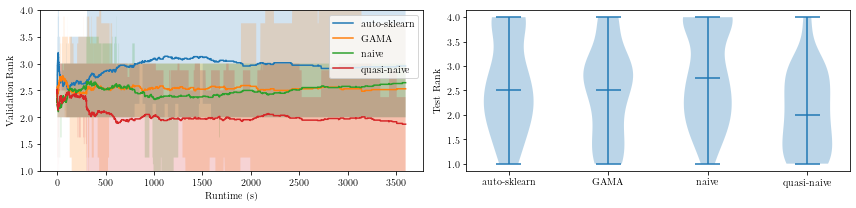

In [76]:
fig = get_plot_ofrank_curves_and_violines(rank_curves_1h, OPTIMIZERS, dfResults, to_1h, False)[0]
fig.savefig("plots/ranks-1h.pdf")
plt.show()

### 1d Time Limit

In [20]:
to_1d = 86400
performance_curves_1d = get_performance_curves(dfResults, to_1d)
rank_curves_1d = get_rank_curves(performance_curves_1d)

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


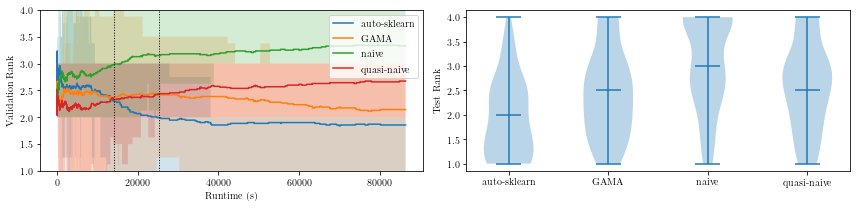

In [83]:
fig, (ax1, ax2) = get_plot_ofrank_curves_and_violines(rank_curves_1d, OPTIMIZERS, dfResults, to_1d, False)
ax1.axvline(14000, linestyle="dotted", linewidth=1, color="black")
ax1.axvline(25200, linestyle="dotted", linewidth=1, color="black")
fig.savefig("plots/ranks-1d.pdf")
plt.show()

## Empirical Gaps

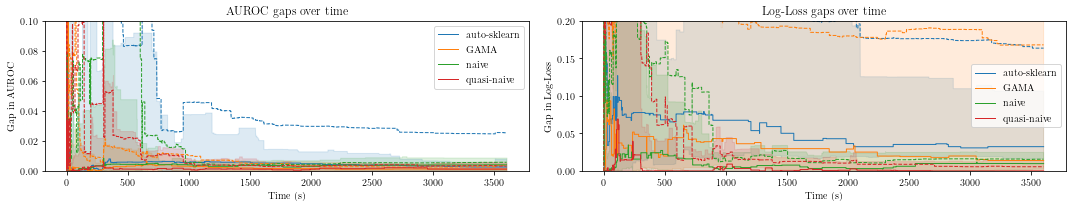

In [67]:
def plot_empirical_gaps_over_time(performance_curves, ax):
    
    curves_for_auc = performance_curves
    algos, times = get_algos_and_times_for_curveset(curves_for_auc)
    datasets = curves_for_auc.keys()
    
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in algos} for openmlid in datasets}
    sup_curves = {openmlid: [] for openmlid in datasets}
    pointwise_gap_curves_mean = {algo: [] for algo in algos}
    pointwise_gap_curves_median = {algo: [] for algo in algos}
    pointwise_gap_curves_q1 = {algo: [] for algo in algos}
    pointwise_gap_curves_q3 = {algo: [] for algo in algos}
    
    for t_index, t in enumerate(times):
        gaps_at_t = {}
        for openmlid, performance_curves_of_dataset in curves_for_auc.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            for algorithm, curve in performance_curves_of_dataset.items():
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    cur_vals[algorithm] = curve["median"][index_of_timestamp]
            
            best_value_at_t = max(cur_vals.values())
            gaps_at_t[openmlid] = {algorithm: min(1, best_value_at_t - cur_vals[algorithm]) if best_value_at_t > -np.inf else 0 for algorithm in algos}
            sup_curves[openmlid].append(best_value_at_t)
            
        for algo in algos:
            gaps_of_algo_at_time = [gaps_at_t[openmlid][algo] for openmlid in datasets]
            pointwise_gap_curves_median[algo].append(np.median(gaps_of_algo_at_time))
            pointwise_gap_curves_mean[algo].append(scipy.stats.trim_mean(gaps_of_algo_at_time, 0.1))
            pointwise_gap_curves_q1[algo].append(np.percentile(gaps_of_algo_at_time, 25))
            pointwise_gap_curves_q3[algo].append(np.percentile(gaps_of_algo_at_time, 75))
    
    for algo in algos:
        color = OPTIMIZER_COLORS[algo]
        ax.step(times, pointwise_gap_curves_median[algo], label=OPTIMIZER_NAMES[algo], color=color, linewidth=1)
        ax.step(times, pointwise_gap_curves_mean[algo], linestyle="--", color=color, linewidth=1)
        ax.fill_between(times, pointwise_gap_curves_q1[algo], pointwise_gap_curves_q3[algo], color=color, alpha=0.15)

fig, ax = plt.subplots(1, 2, figsize=(15, 3))
plot_empirical_gaps_over_time({openmlid: performance_curves_1h[openmlid] for openmlid in datasets_auc}, ax[0])
plot_empirical_gaps_over_time({openmlid: performance_curves_1h[openmlid] for openmlid in datasets_logloss}, ax[1])
ax[0].legend()
ax[0].set_ylim([0, 0.1])
ax[0].set_ylabel("Gap in AUROC")
ax[0].set_xlabel("Time (s)")
ax[0].set_title("AUROC gaps over time")
ax[1].legend()
ax[1].set_ylim([0, 0.2])
ax[1].set_ylabel("Gap in Log-Loss")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Log-Loss gaps over time")
fig.tight_layout()
fig.savefig("plots/gaps-over-time-1h.pdf")
plt.show()
#{openmlid: performance_curves_1h[openmlid] for openmlid in datasets_logloss}

## Absolute Wins Over Time

In [57]:
def plot_absolute_wins_over_time(performance_curves, algo_1, algo_2, ax):
    win_curves = get_win_curves(performance_curves, algo_1, algo_2)
    ax.step(win_curves[0], win_curves[1][0], label=OPTIMIZER_NAMES[algo_1], color=OPTIMIZER_COLORS[algo_1])
    ax.step(win_curves[0], win_curves[1][1], label=OPTIMIZER_NAMES[algo_2], color=OPTIMIZER_COLORS[algo_2])
    ax.legend()
    ax.set_ylim([0, 70])

def get_fig_for_wins(performance_curves, log_scale=False):
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    for i, competitor in enumerate(["auto-sklearn", "gama"]):
        plot_absolute_wins_over_time(performance_curves, competitor, "naive-python", ax[i][0])
        plot_absolute_wins_over_time(performance_curves, competitor, "seminaive-python", ax[i][1])
        for j in range(2):
            ax[i][j].set_ylabel("Absolute Wins")
            ax[i][j].set_xlabel("Time (s)")
            if log_scale:
                ax[i][j].set_xscale("log")
                ax[i][j].set_xlim([300, 86500])
    fig.tight_layout()
    plt.show()
    return fig

### 1h Time Out

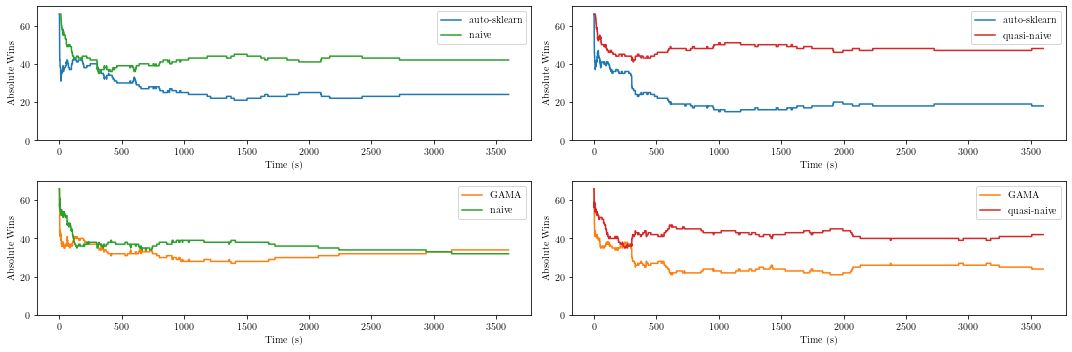

In [68]:
fig = get_fig_for_wins(performance_curves_1h)
fig.savefig("plots/wins-1h.pdf")

### 1d Time Out
#### Standard Scale

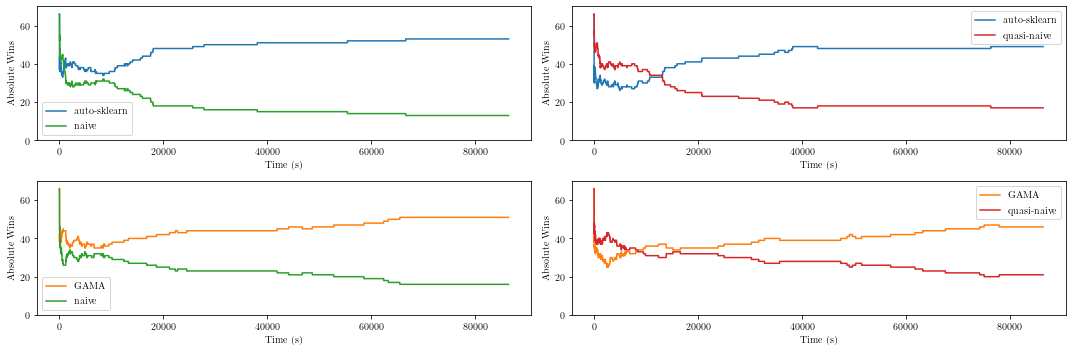

In [69]:
fig = get_fig_for_wins(performance_curves_1d)
fig.savefig("plots/wins-1d.pdf")

#### Log-Scale

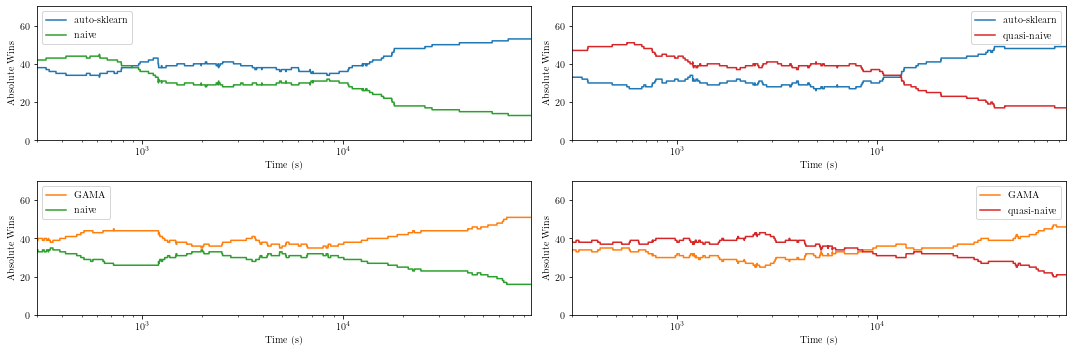

In [70]:
fig = get_fig_for_wins(performance_curves_1d, True)
fig.savefig("plots/wins-1d-log.pdf")

## Test Performance Gaps to Best

In [85]:
def get_optimality_gaps(df):
    gaps = {}
    for openmlid, dfDataset in df.groupby("openmlid"):
        is_max = metrics[openmlid] == "auc"
        medians = {algorithm: np.nanmedian(dfAlgo["metric"].values) for algorithm, dfAlgo in dfDataset.groupby("algorithm")}
        best_median = max(medians.values()) if is_max else min(medians.values())
        gaps_on_dataset = {algo: best_median - median if is_max else median - best_median for algo, median in medians.items()}
        gaps[openmlid] = gaps_on_dataset
    return gaps

def get_gap_plot_for_computed_gaps(gaps, ax):
    
    # compute gaps per algorithm
    gaps_per_algorithm = {}
    for openmlid, gaps_for_dataset in gaps.items():        
        for algo, gap in gaps_for_dataset.items():
            if not algo in gaps_per_algorithm:
                gaps_per_algorithm[algo] = []
            gaps_per_algorithm[algo].append(gap)
    
    # create violinplot
    algos = list(gaps_per_algorithm.keys())
    ax.violinplot([gaps_per_algorithm[algo] for algo in algos], showmedians=True, quantiles=[[.5, .9] for i in range(len(algos))])
    ax.set_xticks(range(1, len(algos) + 1))
    ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
    

def get_gap_plots(df, timeout):    
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    gaps = get_optimality_gaps(df[dfResults["timeout"] == timeout])
    gaps_for_auc = {openmlid: gaps_of_id for openmlid, gaps_of_id in gaps.items() if metrics[openmlid] == "auc"}
    get_gap_plot_for_computed_gaps(gaps_for_auc, ax[0])
    ax[0].set_ylim([0, 0.1])
    ax[0].set_title("Gaps on AUROC datasets")
    gaps_for_log_loss = {openmlid: gaps_of_id for openmlid, gaps_of_id in gaps.items() if metrics[openmlid] == "log_loss"}
    get_gap_plot_for_computed_gaps(gaps_for_log_loss, ax[1])
    ax[1].set_ylim([0, .2])
    ax[1].set_title("Gaps on log-loss datasets")
    return fig, ax

### 1h Time Limit

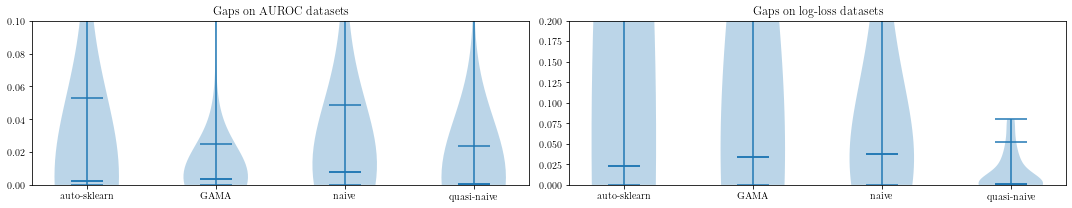

In [86]:
fig = get_gap_plots(dfResults, 3600)[0]
fig.tight_layout()
fig.savefig("plots/gaps-1h.pdf")
plt.show()

### 1d Time Limit

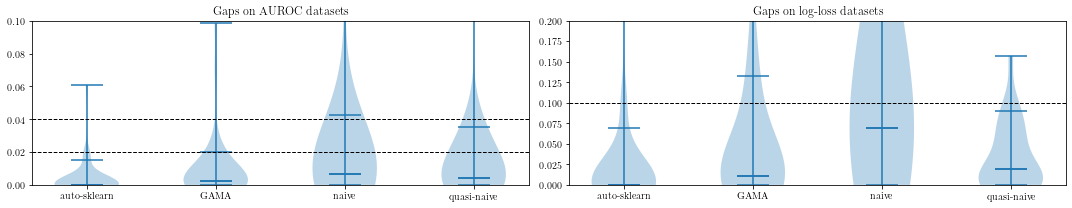

In [89]:
fig, ax = get_gap_plots(dfResults, 86400)
ax[0].axhline(0.02, color="black", linestyle="--", linewidth=1)
ax[0].axhline(0.04, color="black", linestyle="--", linewidth=1)
ax[1].axhline(0.1, color="black", linestyle="--", linewidth=1)
fig.tight_layout()
fig.savefig("plots/gaps-1d.pdf")
plt.show()

In [90]:
dfTmp = pd.read_csv("/home/felix/devel/naiveautoml/python/singularity/tmp/591ff1d9-524a-4c78-8edc-c6bd99f83115/train.csv")
dfTmp

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V70,V71,V72,V73,V74,V75,V76,V77,V78,class
0,0,31.0,3,1,0,0,0.0,1,1,0.0,...,8.0,1.0,5,43,88,1,43,1622,1276,0
1,0,-1.0,5,0,11743,40,8.0,4,34,0.0,...,NaN,61.0,2,43,103,0,103,8535,2548,1
2,1,0.0,25,0,0,0,6.0,9,29,1.0,...,8.0,NaN,2,43,43,0,43,8969,1525,0
3,0,76.0,9,9,8614,52,3.0,9,69,0.0,...,NaN,13.0,4,43,43,1,43,8201,1542,0
4,5,25.0,595,8,7,8,8.0,8,202,1.0,...,NaN,48.0,47,43,43,12,43,569,786,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382711,20,-1.0,44,8,1218,30,20.0,24,27,1.0,...,59.0,39.0,0,43,43,1,65,6145,785,0
382712,3,2.0,4,15,1313,15,3.0,15,16,2.0,...,NaN,56.0,0,43,43,0,103,7779,623,0
382713,0,16.0,2,1,6873,1,2.0,1,1,0.0,...,48.0,56.0,28,43,88,0,43,5995,2154,0
382714,0,0.0,12,1,5653,743,0.0,1,1,0.0,...,NaN,NaN,3,43,43,0,103,2345,2726,1


In [ ]:
for i, row in dfTmp.iterrows():
    print

# Appendix

## Dataset Descriptions

In [80]:
datasets = [int(i) for i in pd.unique(dfResults["openmlid"])]
rows = []
for openmlid in datasets:
    
    # load dataset object
    dataset = openml.datasets.get_dataset(openmlid)
    
    # analyze columns of data
    dfDataset = dataset.get_data()[0]
    types = dfDataset.dtypes
    cnt_normalized = 0
    cnt_zero_mean = 0
    cnt_one_std = 0
    cnt_numerical = 0
    for i, col in enumerate(dfDataset.columns):
        if "float" in str(types[i]):
            cnt_numerical += 1
            vals = dfDataset[col].values
            is_normalized = np.round(min(vals), 3) == 0 and np.round(max(vals), 3) == 1
            is_zero_mean = np.round(np.mean(vals), 3) == 0
            is_one_std = np.round(np.std(vals), 3) == 1
            if is_normalized:
                cnt_normalized += 1
            if is_zero_mean:
                cnt_zero_mean += 1
            if is_one_std:
                cnt_one_std += 1
    if cnt_numerical > 0:
        feature_stats_entries = [str(v) + "\%" for v in np.round(100 * np.array([cnt_normalized / cnt_numerical, cnt_zero_mean / cnt_numerical, cnt_one_std / cnt_numerical]), 0).astype(int)]
    else:
        feature_stats_entries = 3 * ["n/a"]
        
    row = [openmlid, dataset.name[:20].replace("_", "\\_"), int(dataset.qualities["NumberOfInstances"]), len(dataset.features) - 1, int(dataset.qualities["NumberOfNumericFeatures"]), int(dataset.qualities["NumberOfClasses"]), str(int(dataset.qualities["MinorityClassPercentage"])) + "\%", str(int(dataset.qualities["MajorityClassPercentage"])) + "\%", str(int(dataset.qualities["PercentageOfMissingValues"])) + "\%"] + feature_stats_entries
    rows.append(row)
dfDatasets = pd.DataFrame(rows, columns=["openmlid", "name", "instances", "features", "numeric features", "classes", "min \%", "maj \%", "\% missing", "\% [0,1]", "\% $\mu = 0$", "\% $\sigma = 1$"]).sort_values("openmlid")

DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.datase

In [73]:
print(dfDatasets.to_latex(index=False,escape=False))

\begin{tabular}{rlrrrrllllll}
\toprule
 openmlid &                  name &  instances &  features &  numeric features &  classes & min \% & maj \% & \% missing & \% [0,1] & \% $\mu = 0$ & \% $\sigma = 1$ \\
\midrule
        3 &              kr-vs-kp &       3196 &        36 &                 0 &        2 &   47\% &   52\% &        0\% &      n/a &          n/a &             n/a \\
       12 &         mfeat-factors &       2000 &       216 &               216 &       10 &   10\% &   10\% &        0\% &      n/a &          n/a &             n/a \\
       23 &                   cmc &       1473 &         9 &                 2 &        3 &   22\% &   42\% &        0\% &      n/a &          n/a &             n/a \\
       31 &              credit-g &       1000 &        20 &                 7 &        2 &   30\% &   70\% &        0\% &      0\% &          0\% &             0\% \\
       54 &               vehicle &        846 &        18 &                18 &        4 &   23\% &   25\% &   

In [90]:
for col in ["instances", "features", "numeric features", "classes", "minority %", "majority %", "% missing vals"]:
    print(col)
    vals = dfDatasets[col]
    if "%" in col:
        vals = [int(v[:v.index("%")]) for v in dfDatasets[col]]
    print("\tMin:", min(vals))
    print("\tMax:", max(vals))
    print("\tQ1:", np.percentile(vals, 25))
    print("\tQ3:", np.percentile(vals, 75))
    print("\tIQR:", np.percentile(vals, 75) - np.percentile(vals, 25))
    print("\tRange:", max(vals) - min(vals))
    print("\tMean:", np.mean(vals))
    print("\tMedian:", np.median(vals))
    print("\tStd:", np.std(vals))

instances
	Min: 100
	Max: 2215023
	Q1: 2534.0
	Q3: 48842.0
	IQR: 46308.0
	Range: 2214923
	Mean: 72606.09836065574
	Median: 5404.0
	Std: 287234.64885526383
features
	Min: 4
	Max: 10000
	Q1: 19.0
	Q3: 230.0
	IQR: 211.0
	Range: 9996
	Mean: 750.3770491803278
	Median: 42.0
	Std: 2036.1246875080656
numeric features
	Min: 0
	Max: 10000
	Q1: 7.0
	Q3: 192.0
	IQR: 185.0
	Range: 10000
	Mean: 713.5737704918033
	Median: 27.0
	Std: 2038.7437988488894
classes
	Min: 2
	Max: 355
	Q1: 2.0
	Q3: 5.0
	IQR: 3.0
	Range: 353
	Mean: 11.852459016393443
	Median: 2.0
	Std: 46.41220729244104
minority %
	Min: 0
	Max: 50
	Q1: 5.0
	Q3: 40.0
	IQR: 35.0
	Range: 50
	Mean: 20.39344262295082
	Median: 13.0
	Std: 17.999343055884825
majority %
	Min: 0
	Max: 98
	Q1: 41.0
	Q3: 76.0
	IQR: 35.0
	Range: 98
	Mean: 54.83606557377049
	Median: 52.0
	Std: 27.24881127072943
% missing vals
	Min: 0
	Max: 69
	Q1: 0.0
	Q3: 0.0
	IQR: 0.0
	Range: 69
	Mean: 1.4918032786885247
	Median: 0.0
	Std: 8.860712606541702


## Performances Over Time

In [36]:
def plot_performances_over_time(performance_curves, suffix, algorithm_order = None, ax = None):
    last_timestamps_asklearn = []
    last_timestamps_seminaive = []
    axises = {}
    
    if ax is not None and len(performance_curves) > 1:
        raise Exception("Axis object can only be delivered if there is information for a single dataset!")
    
    for openmlid, curves in performance_curves.items():
        metric = metrics[openmlid]
        best_final_value = max([c["median"][-1] if len(c) > 0 and len(c["median"]) > 0 else -np.inf for algo, c in curves.items()])

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 2))
        else:
            fig = None

        all_median_values = []
        
        algos = curves.keys() if algorithm_order is None else algorithm_order
        
        for algorithm in algos:
            curve = curves[algorithm]
            for v in curve["median"]:
                if not np.isnan(v) and v != -np.inf and v != np.inf:
                    all_median_values.append(v)
            if len(curve["times"]) > 0:
                last_timestamps_asklearn.append(curve["times"][-1])
            add_curve_to_plot(curve, ax, OPTIMIZER_COLORS[algorithm], OPTIMIZER_NAMES[algorithm])

        # adjust axis limits
        v_min = np.percentile(all_median_values, 5)
        v_max_theory = 1 if metric == "auc" else 0
        v_max_data = max(all_median_values) + (0.01 if metric == "auc" else 0.1)
        v_max = min(v_max_theory, v_max_data)
        ax.set_title("Performances on " + str(openmlid) + " (" + datasetnames[openmlid] + ")")
        ax.set_xscale("log")
        ax.set_xlabel("Runtime (s)")
        ax.set_ylabel("AUROC" if metric == "auc" else "Neg Log-Loss")
        #ax.set_ylim([v_min, v_max])
        #ax.legend()
        if not fig is None:
            fig.tight_layout()
            fig.savefig("plots/runs/" + str(openmlid) + "_" + suffix + ".pdf")
        axises[openmlid] = ax

        # plot curve
        #plt.show()
    return axises

### 1h Time Limit

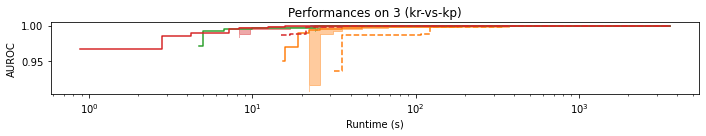

In [33]:
axises_1h = plot_performances_over_time(performance_curves_1h, "1h", algorithm_order=OPTIMIZERS)

### 1d Time Limit

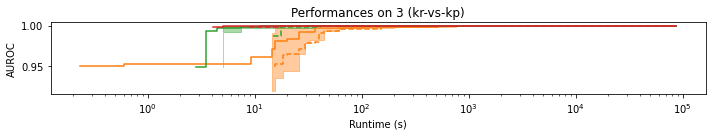

In [34]:
axises_1d = plot_performances_over_time(performance_curves_1d, "1d", algorithm_order=OPTIMIZERS)

### Create Combined Images and Create Latex Code

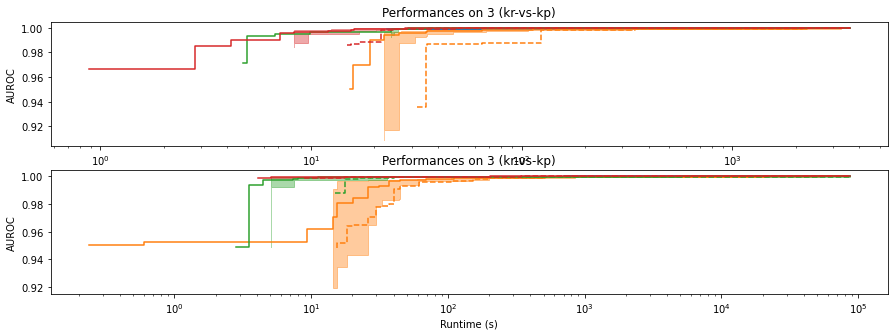

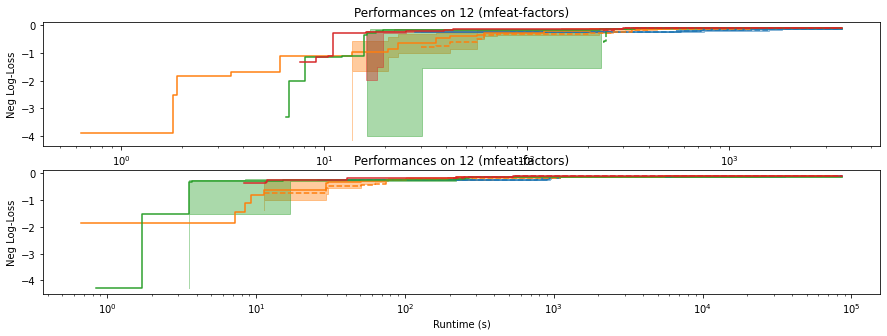

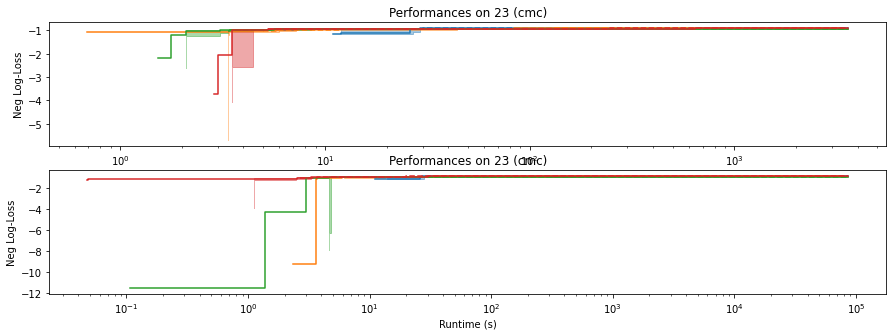

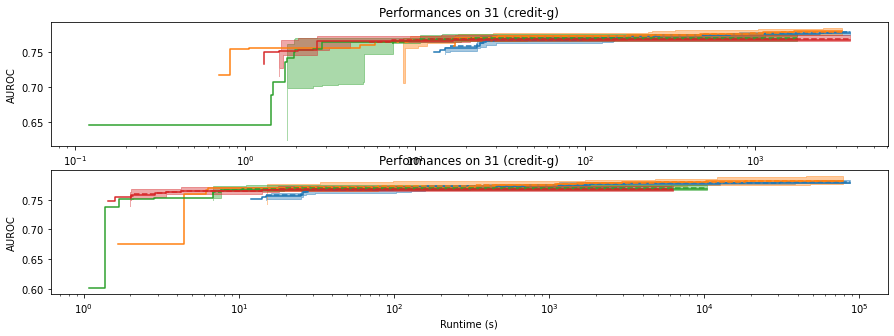

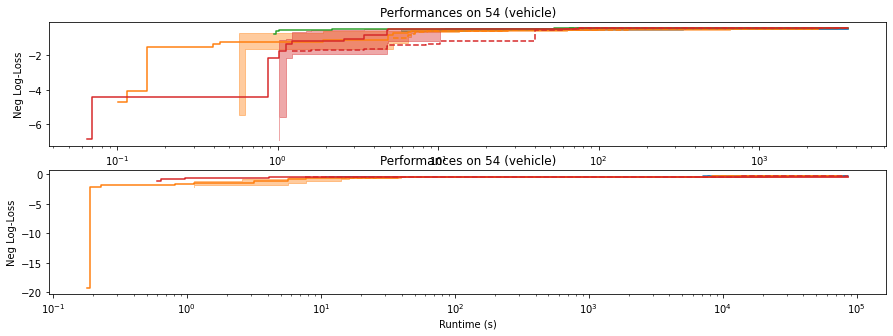

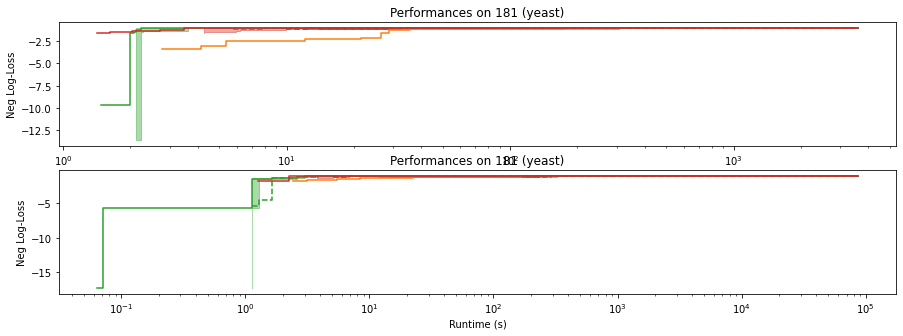

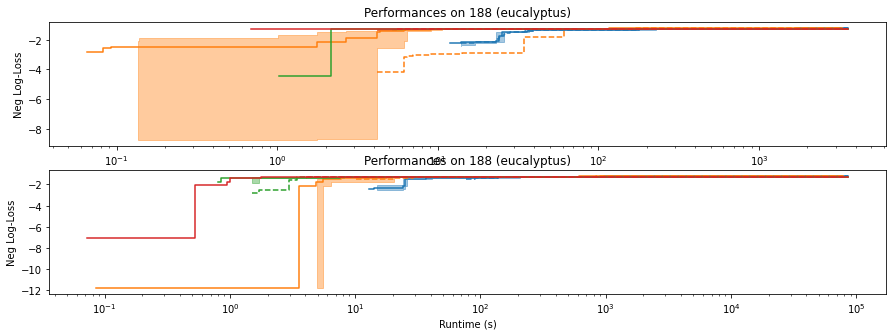

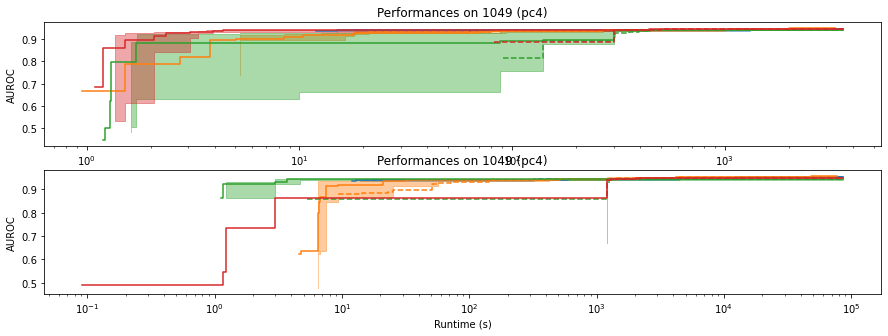

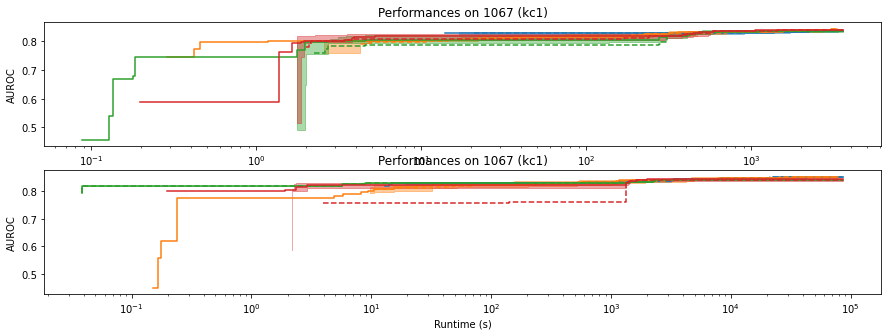

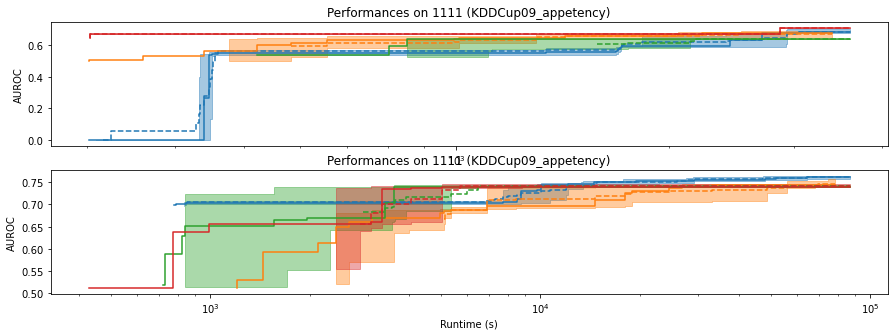

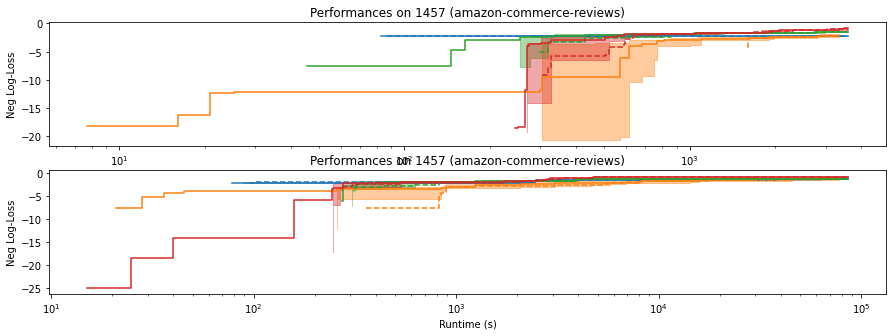

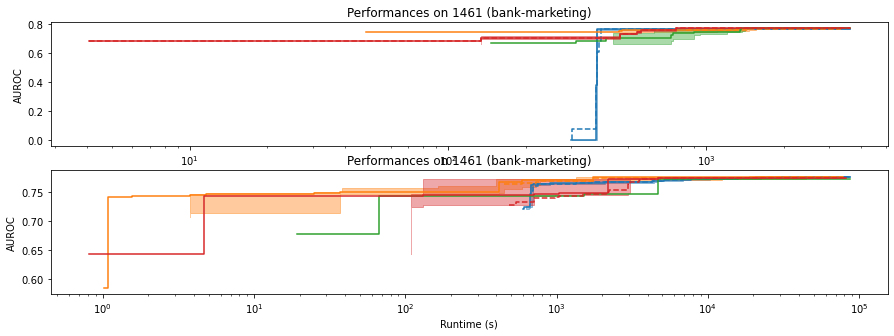

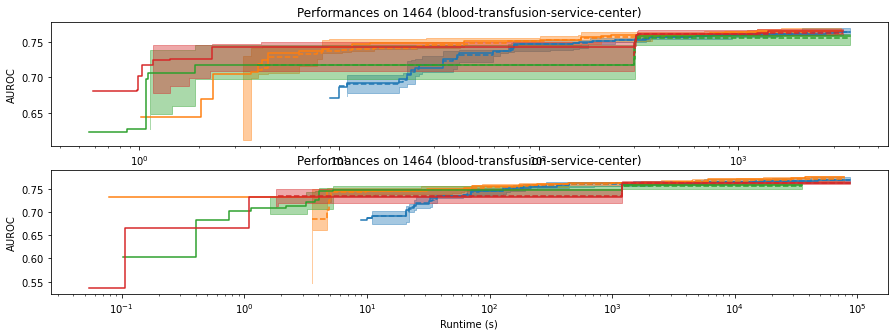

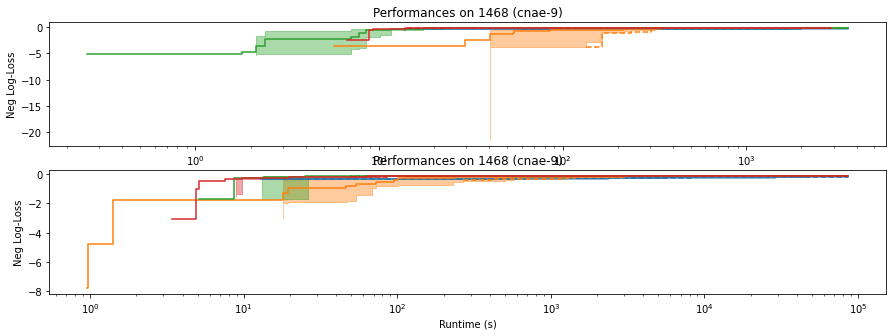

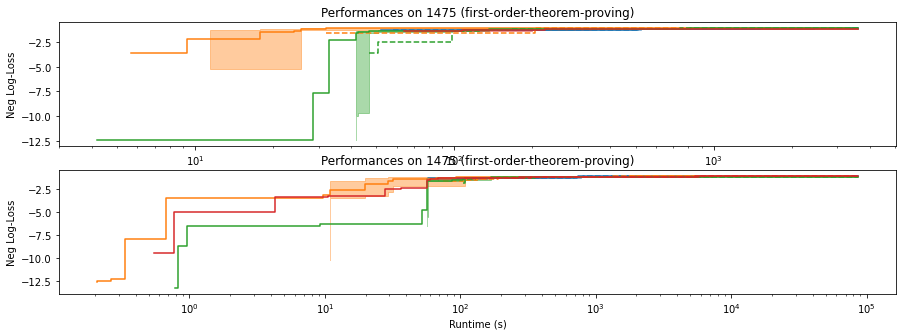

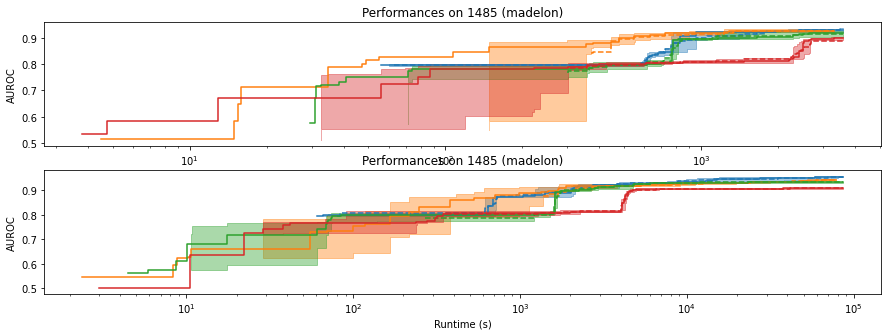

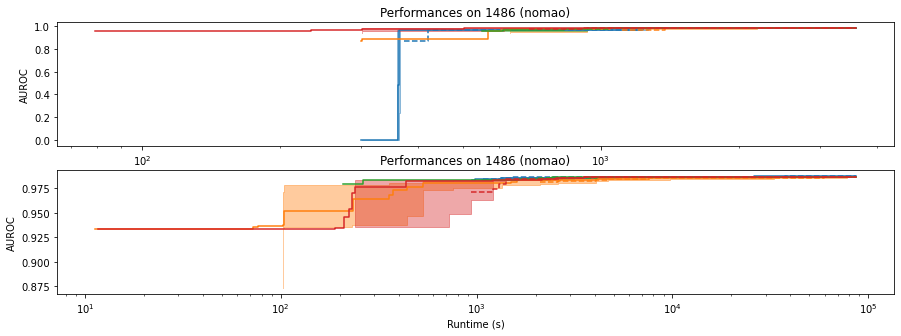

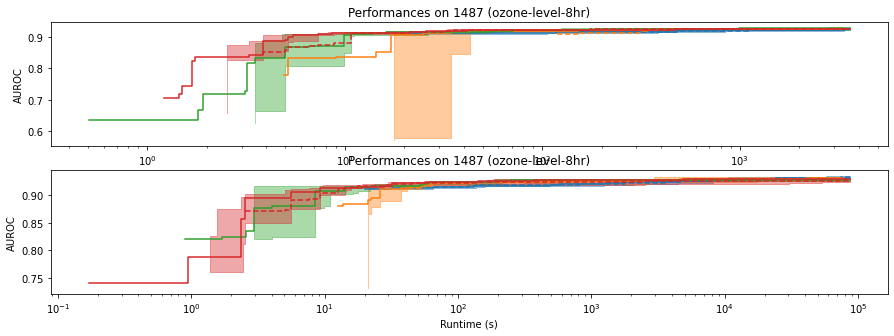

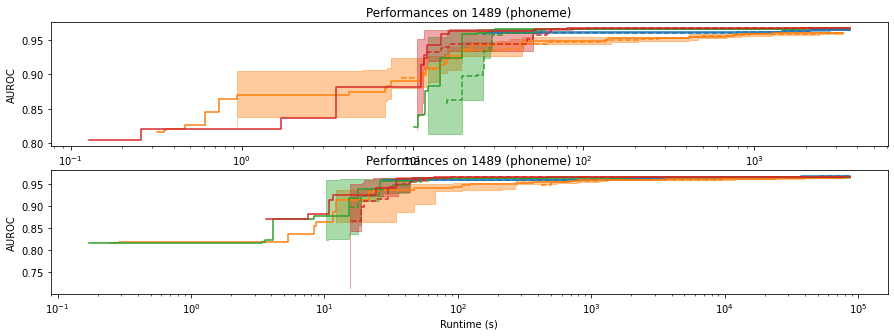

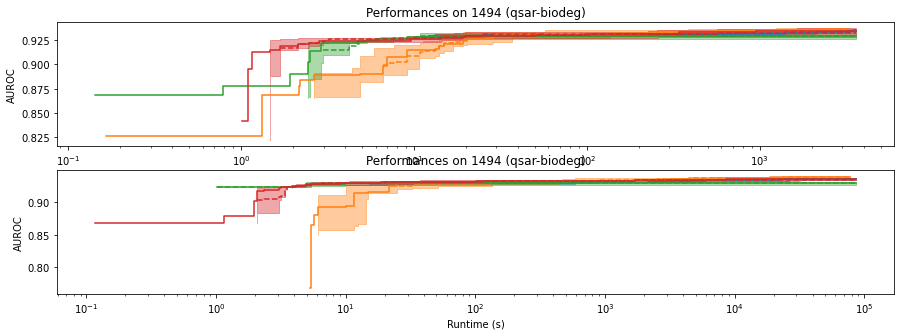

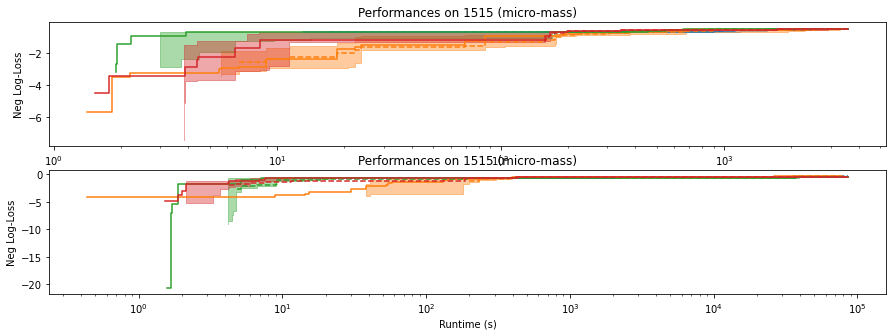

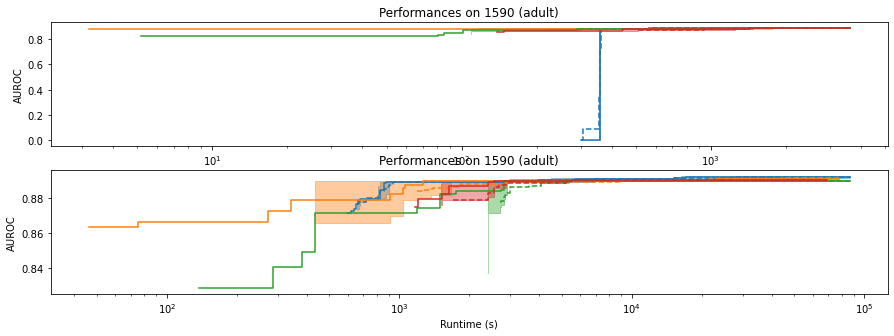

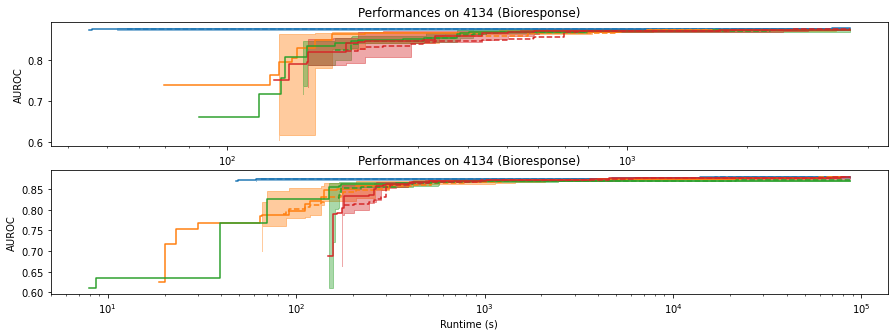

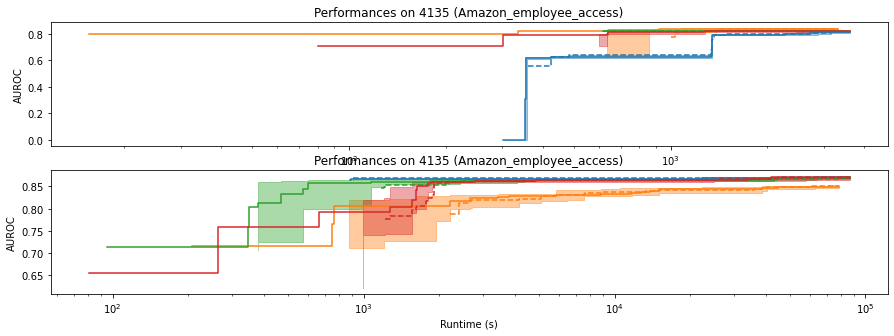

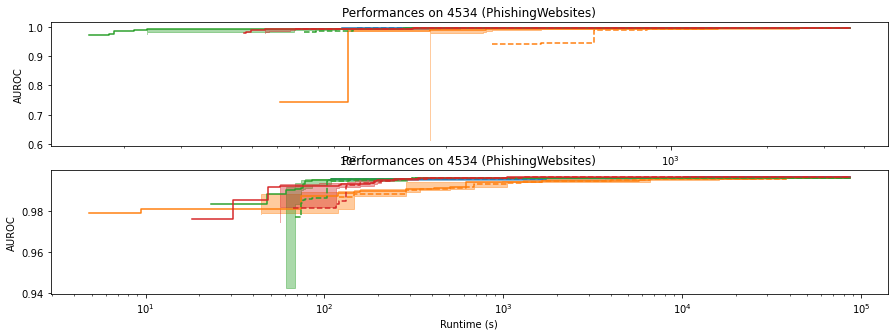

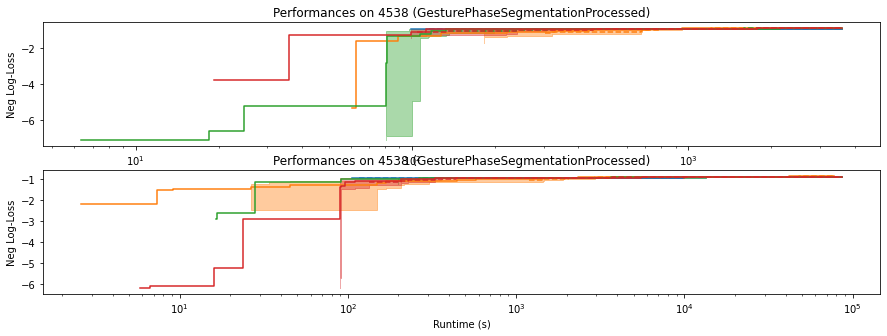

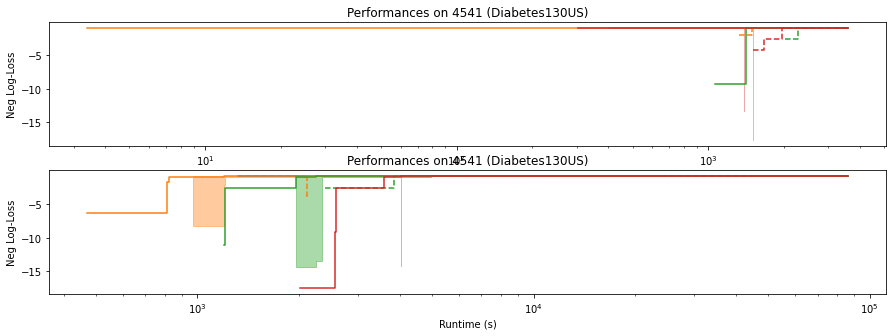

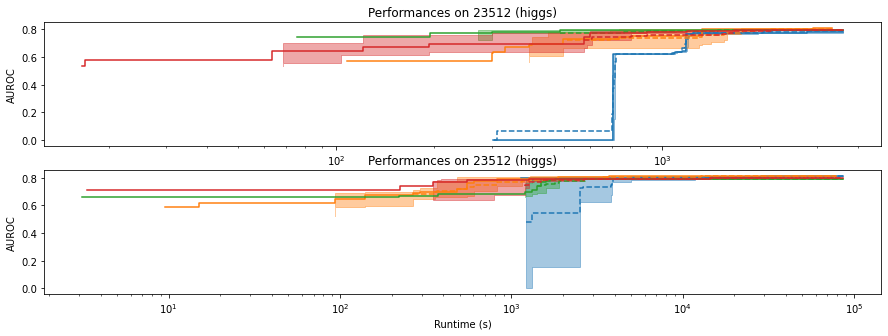

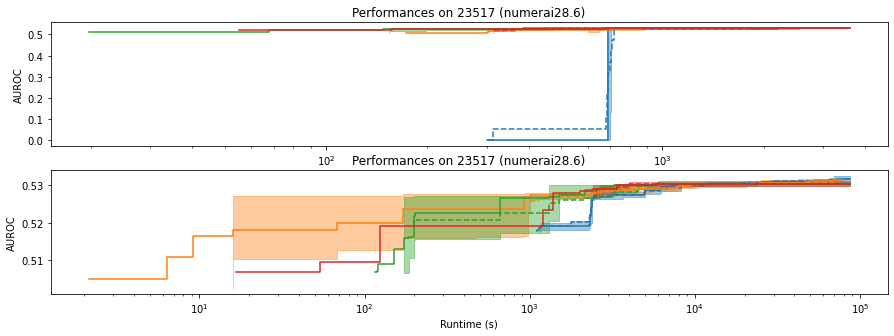

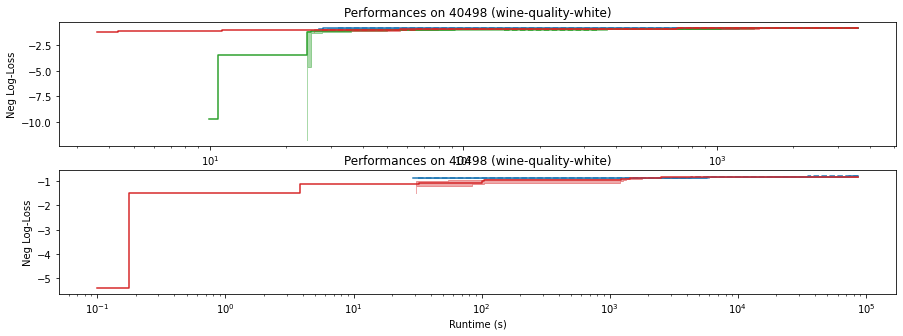

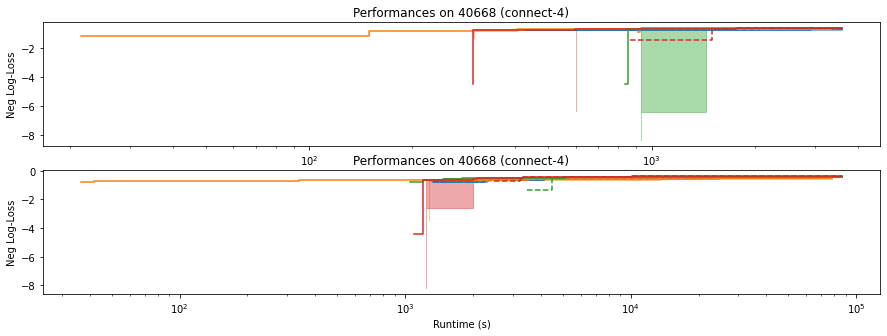

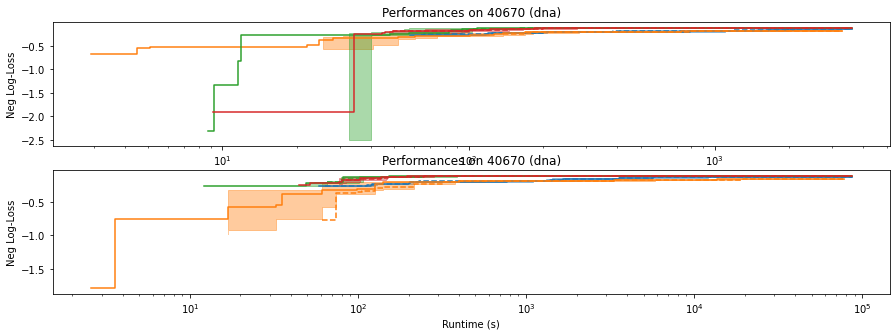

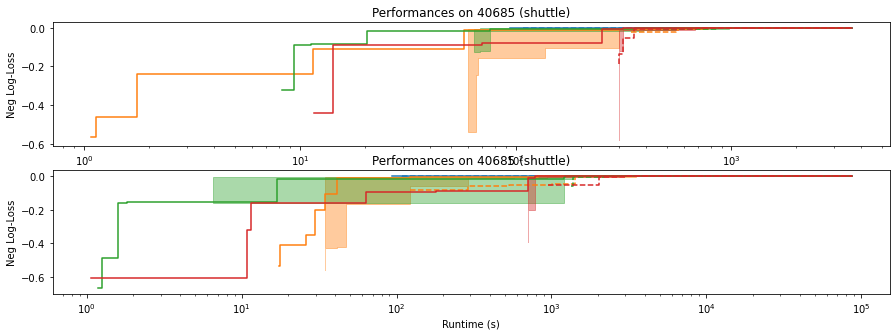

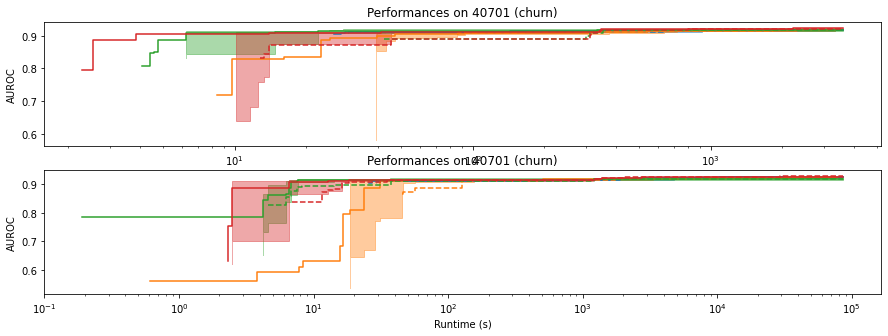

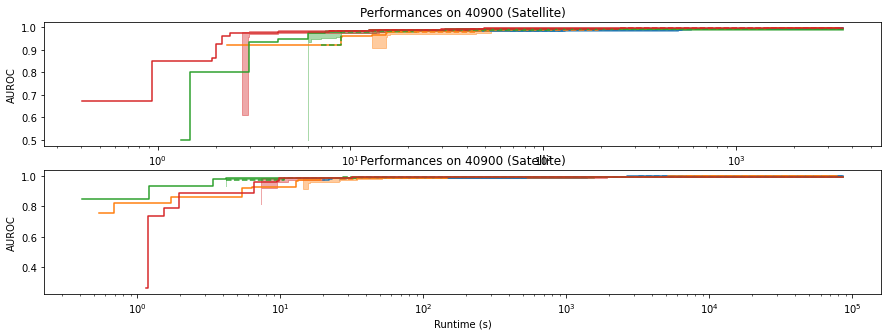

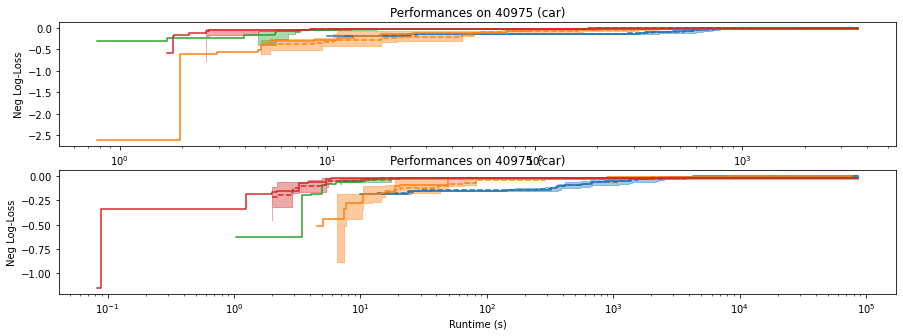

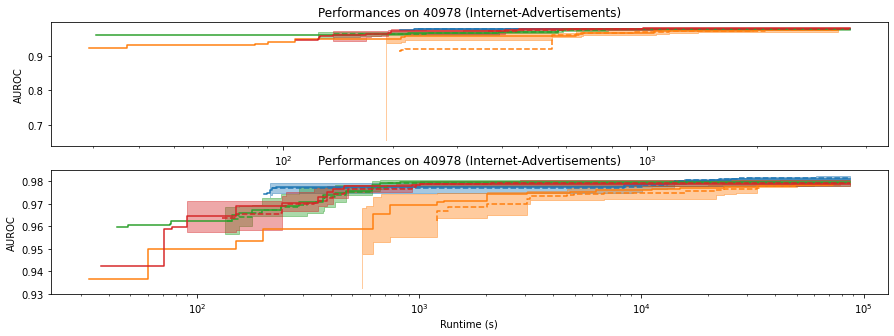

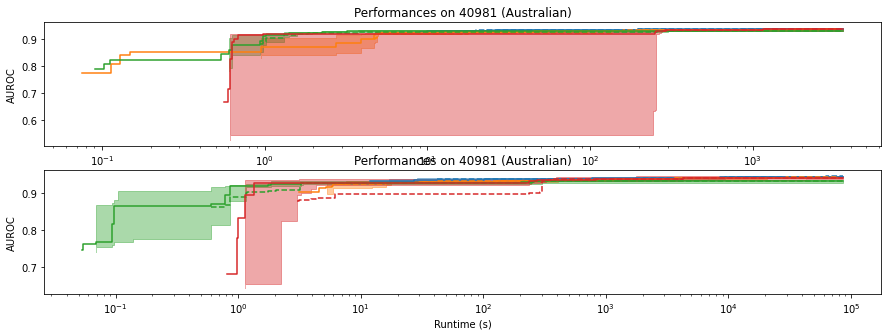

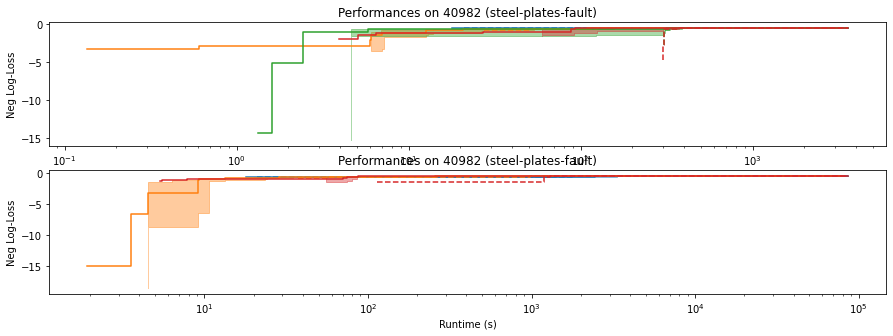

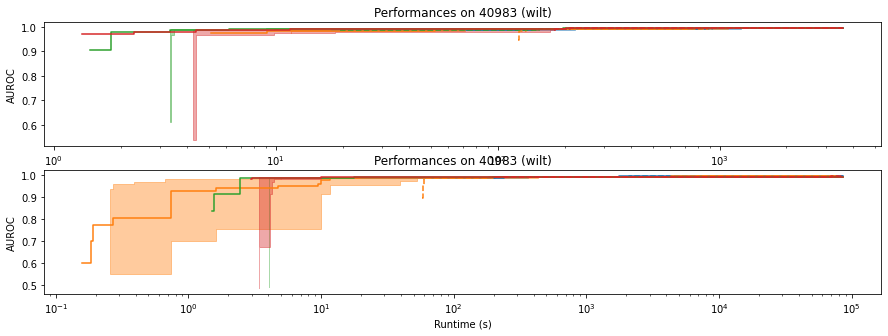

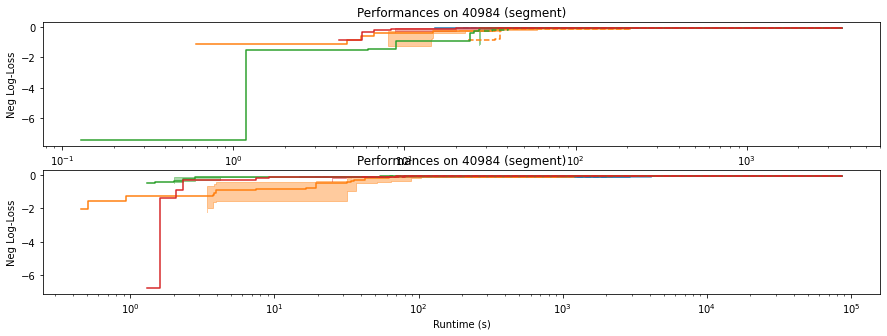

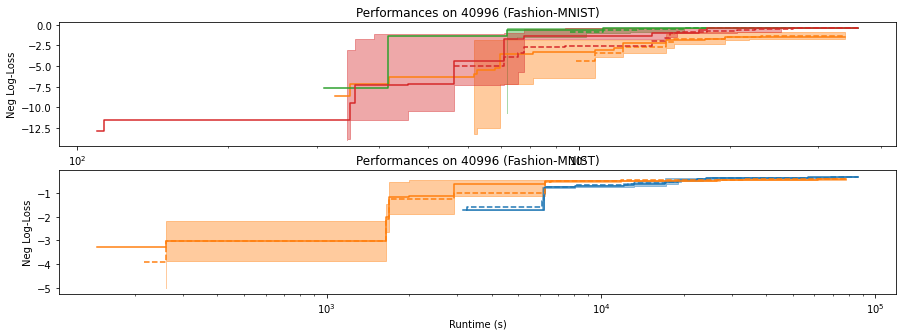

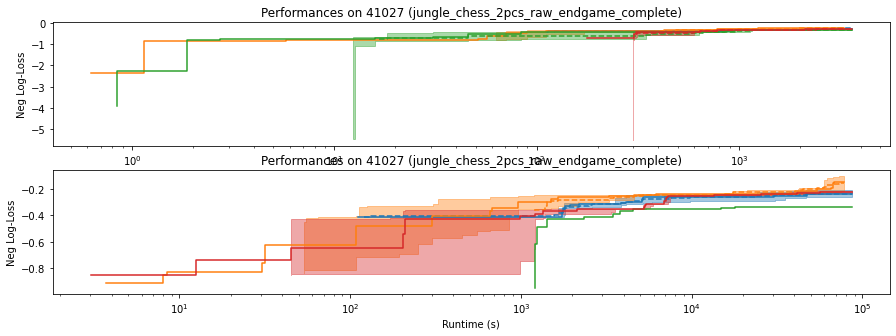

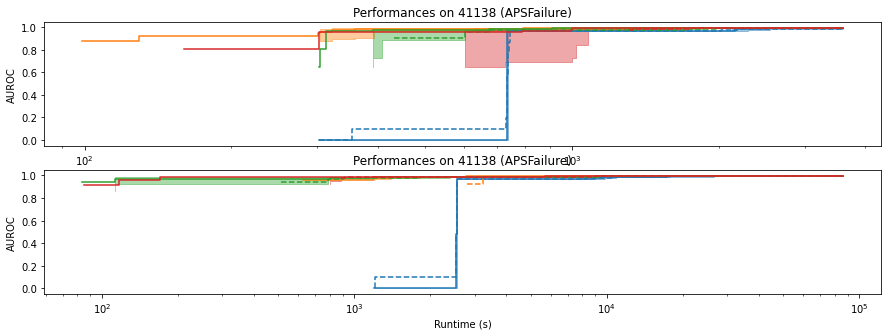

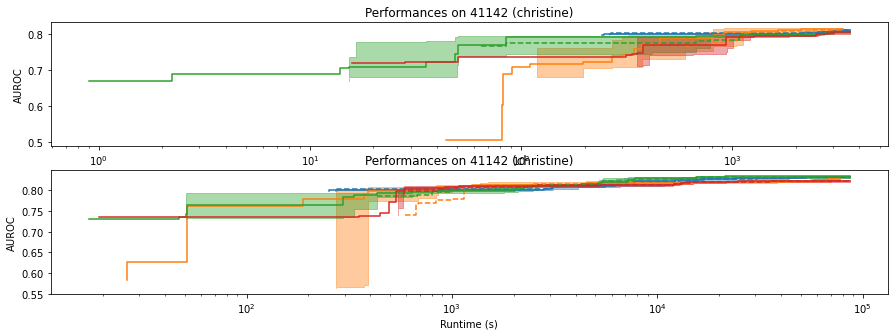

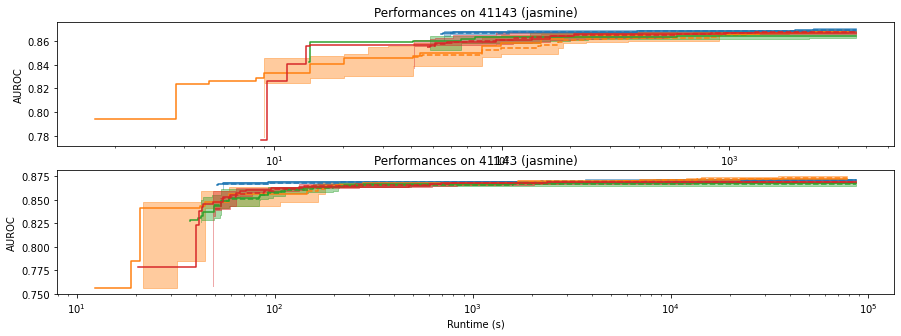

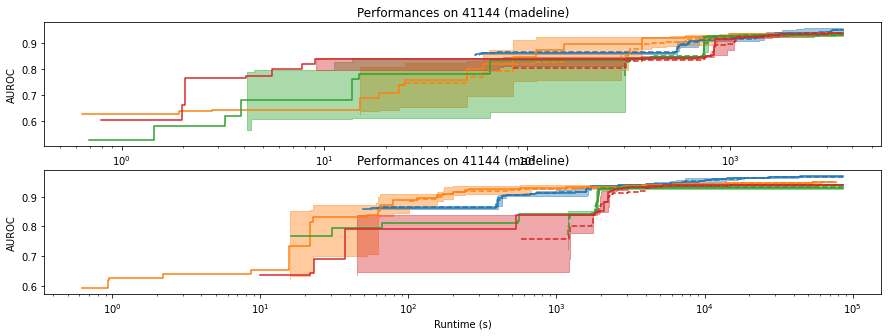

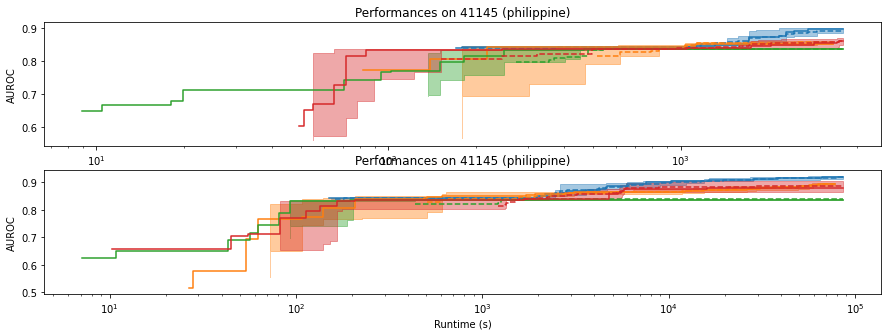

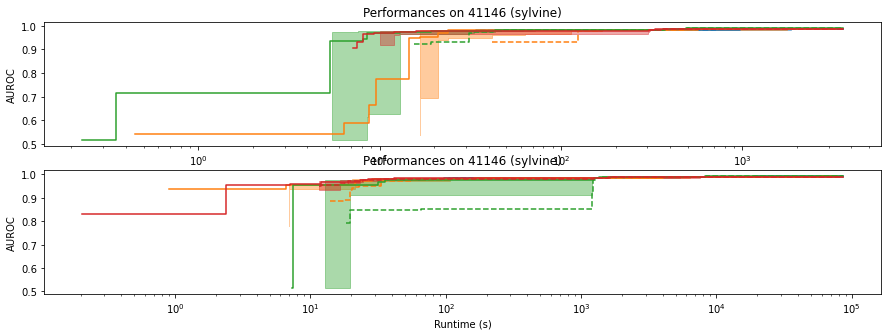

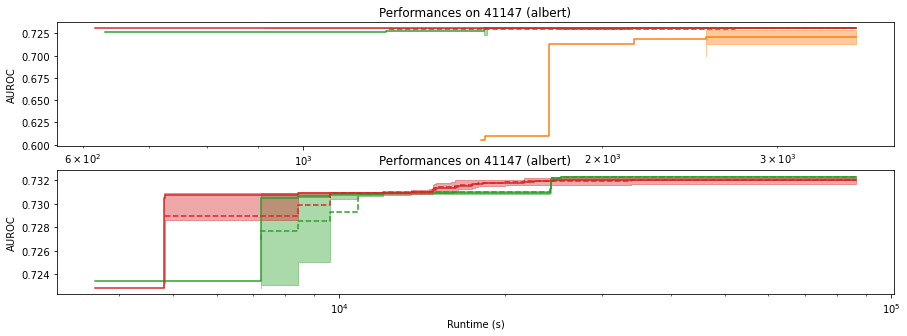

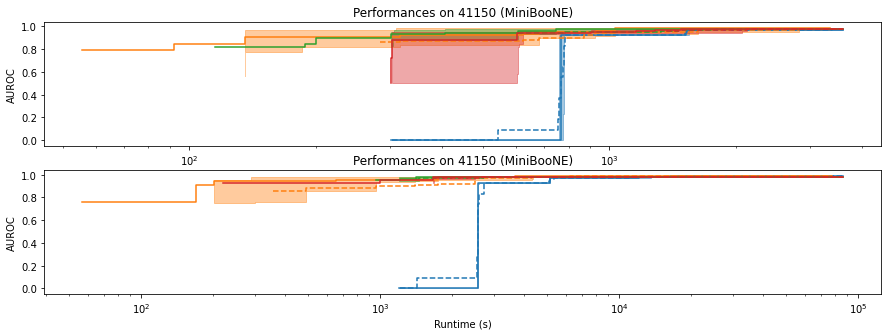

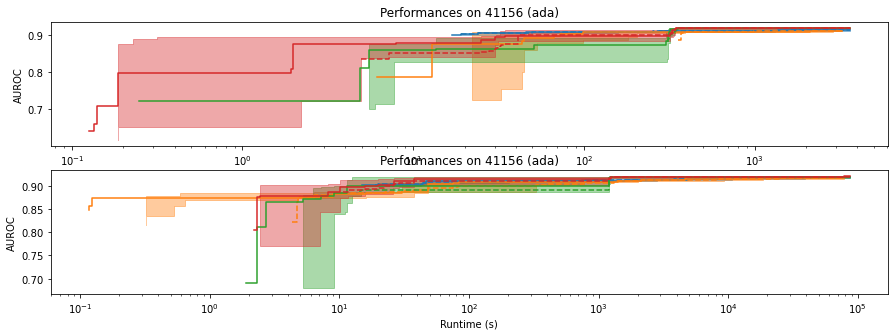

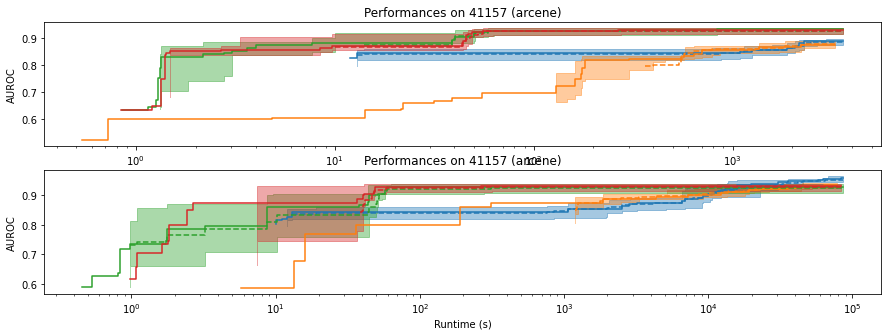

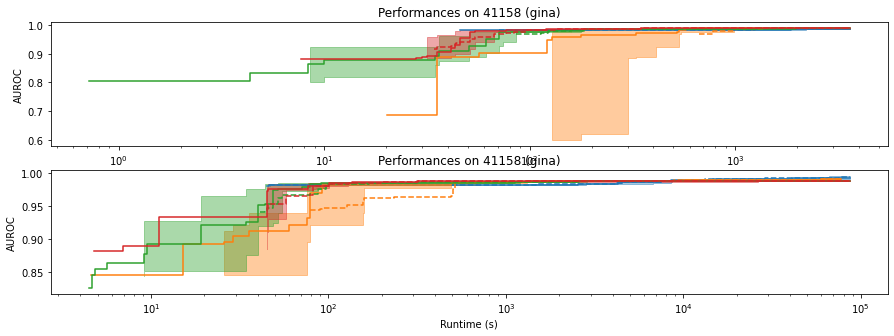

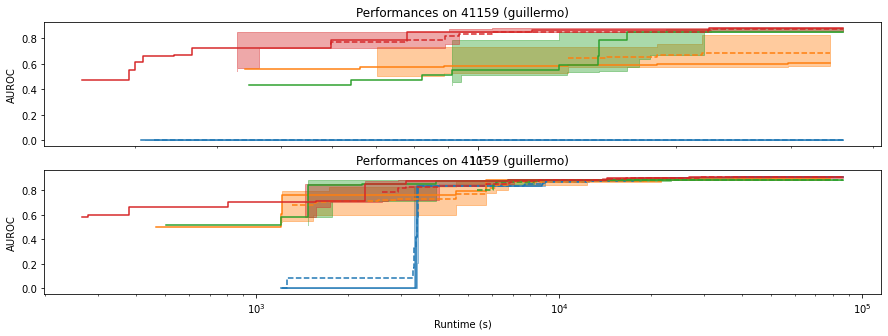

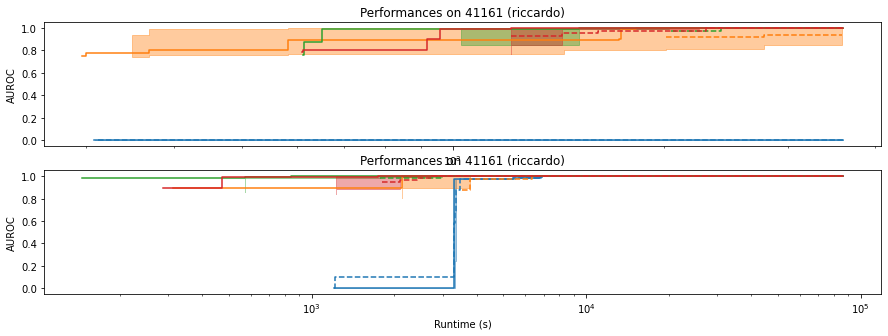

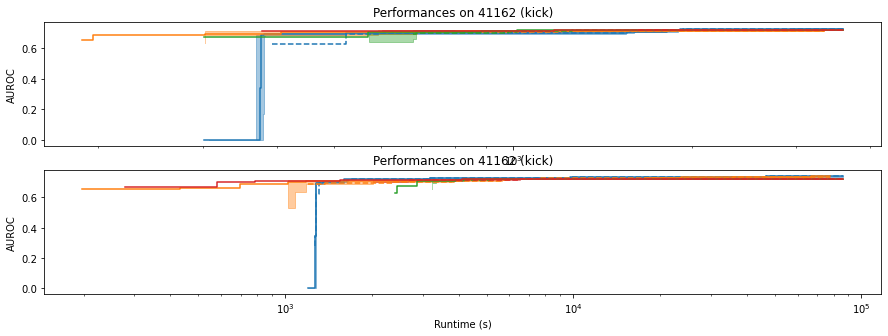

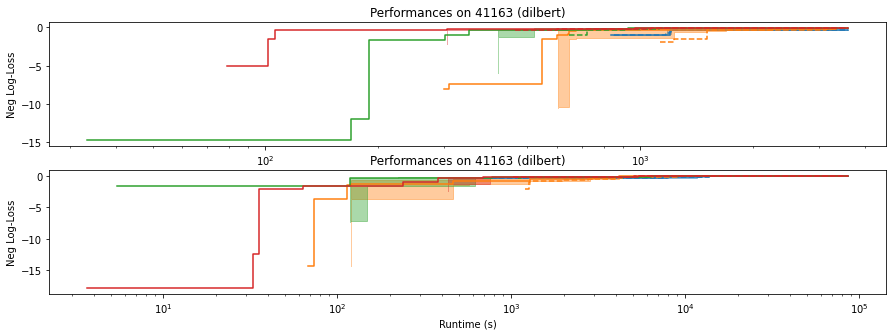

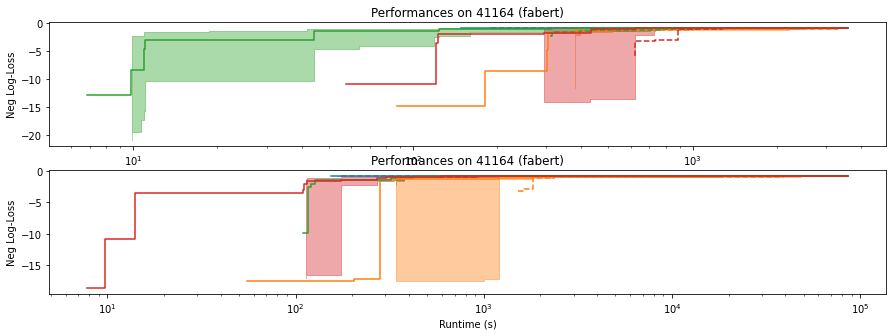

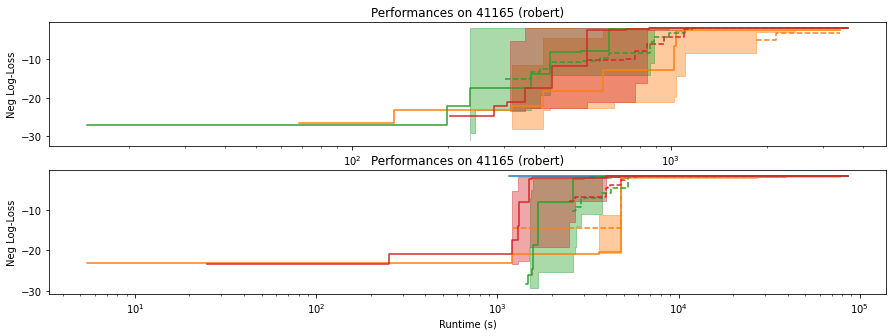

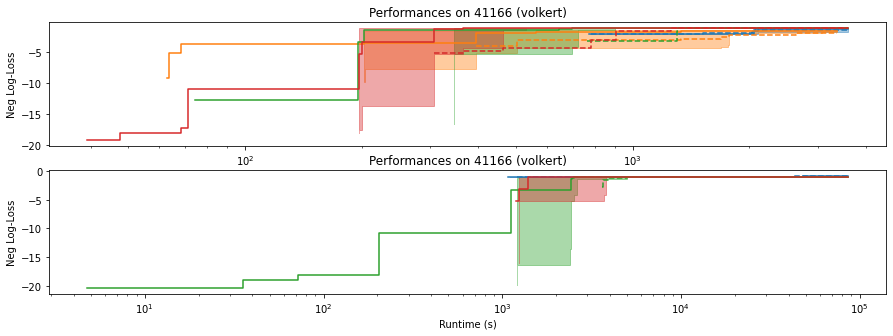

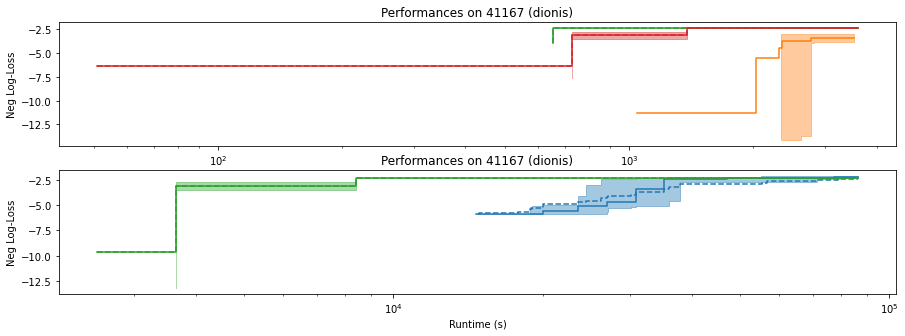

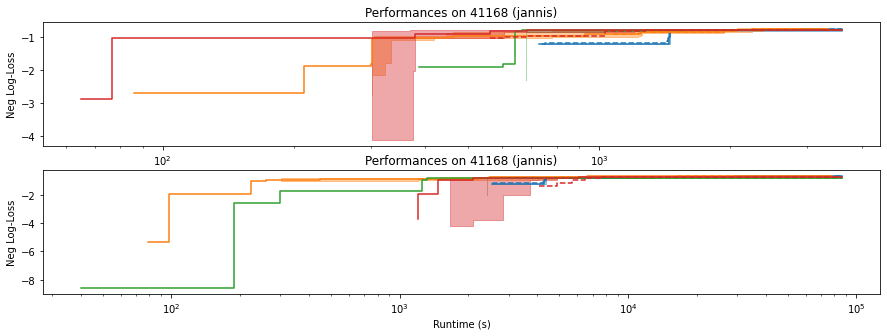

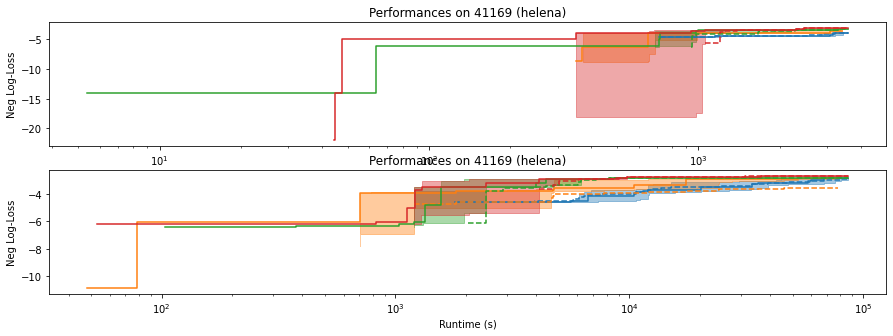

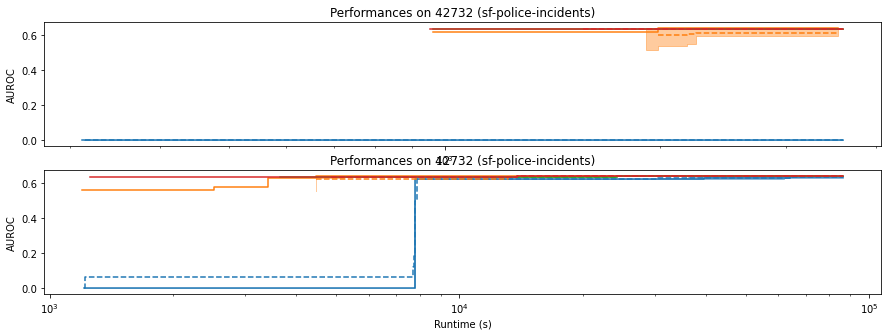

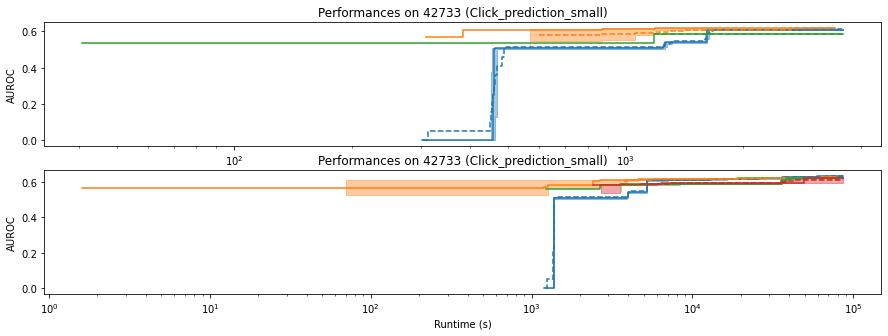

In [38]:
for openmlid in sorted(datasets):
    fig, (ax_1h, ax_1d) = plt.subplots(2, 1, figsize=(15, 5))
    relevant_1h = {openmlid: performance_curves_1h[openmlid]}
    relevant_1d = {openmlid: performance_curves_1d[openmlid]}
    plot_performances_over_time(relevant_1h, "1h", algorithm_order=OPTIMIZERS, ax=ax_1h)
    plot_performances_over_time(relevant_1d, "1d", algorithm_order=OPTIMIZERS, ax=ax_1d)
    plt.show()

In [111]:
latex = ""
i = 0
n = 6
for chunk in (datasets[i:i+n] for i in range(0, len(datasets), n)):
    print("\\begin{figure}")
    for openmlid in chunk:
        print("\\includegraphics[width=\\textwidth]{fig/runplots/" + str(openmlid) + "_1h.pdf}\\\\")
        print("\\includegraphics[width=\\textwidth]{fig/runplots/" + str(openmlid) + "_1d.pdf}\\\\")
    print("\\end{figure}")

\begin{figure}
\includegraphics[width=\textwidth]{fig/runplots/1485_1h.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1485_1d.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1590_1h.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1590_1d.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1515_1h.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1515_1d.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1457_1h.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1457_1d.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1475_1h.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1475_1d.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1468_1h.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1468_1d.pdf}\\
\end{figure}
\begin{figure}
\includegraphics[width=\textwidth]{fig/runplots/1486_1h.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1486_1d.pdf}\\
\includegraphics[width=\textwidth]{fig/runplots/1489_1h.pdf}\\
\includegrap

# Other insights not contained in the paper

## Selections Made

dict_keys(['auto-sklearn', 'naive-python', 'seminaive-python'])


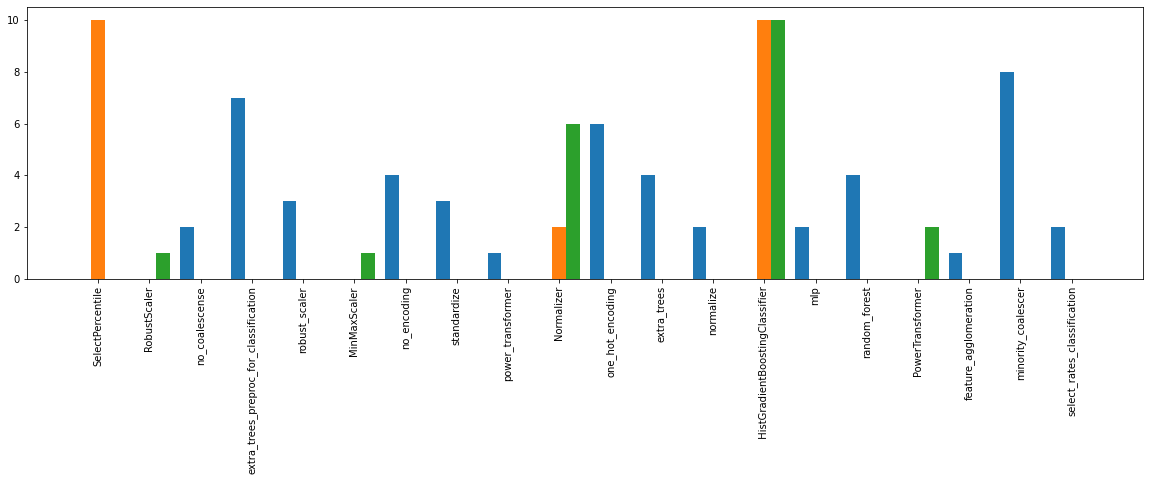

In [264]:
import re

def visualize_selections_on_dataset(dfResults, openmlid):
    
    # gathering information
    occurring = set([])
    selections = {}
    for algorithm, dfAlgo in dfResults[dfResults["openmlid"] == openmlid].groupby("algorithm"):
        if not algorithm in selections:
            selections[algorithm] = {}
        if algorithm == "auto-sklearn":
            for i, row in dfAlgo.iterrows():
                chosen_model = row["chosenmodel"]
                chosen_model = chosen_model[chosen_model.index("SimpleClassificationPipeline(") + len("SimpleClassificationPipeline("):-6]
                chosen_model = chosen_model[:chosen_model.rindex("{")]
                chosen_model = chosen_model[:chosen_model.rindex("}") + 1]
                chosen_model = ast.literal_eval(chosen_model)
                for key, val in chosen_model.items():
                    if "__choice__" in key and val != "none":
                        occurring.add(val)
                        if not val in selections[algorithm]:
                            selections[algorithm][val] = 0
                        selections[algorithm][val] += 1
        
        if "naive" in algorithm:
            for i, row in dfAlgo.iterrows():
                for step in ["data-pre-processor", "feature-pre-processor", "classifier"]:
                    match = re.search("\\('" + step + "',\s([^(]*)", row["chosenmodel"])
                    if match is not None:
                        val = match.group(1)
                        occurring.add(val)
                        if not val in selections[algorithm]:
                            selections[algorithm][val] = 0
                        selections[algorithm][val] += 1
    
    def subcategorybar(X, vals, ax, width=0.8):
        n = len(vals)
        _X = np.arange(len(X))
        for i in range(n):
            ax.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge")   
        ax.set_xticks(range(len(X)))
        ax.set_xticklabels(X, rotation=90)
    
    # plotting histograms
    fig, ax = plt.subplots(figsize=(20, 5))
    occurring = list(occurring)
    counts = [[selections[algorithm][s] if s in selections[algorithm] else 0 for s in occurring] for algorithm in selections.keys()]
    subcategorybar(occurring, counts, ax)
    print(selections.keys())
        
        
visualize_selections_on_dataset(dfResults[dfResults["timeout"] == 86400], 1485)

3 auc
Best score: 1.0
Win for auto-sklearn
	auto-sklearn 1.0 (0.0001)
	naive-python 0.9999 (0.0023)
Win for seminaive-python
	seminaive-python 1.0 (0.0002)


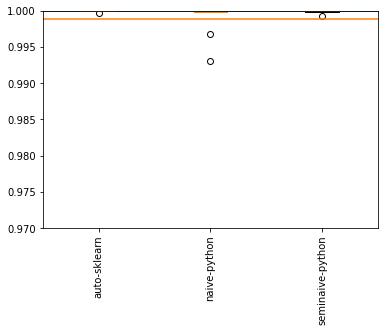

12 log_loss
Best score: 0.11653603037721322
Win for auto-sklearn
	auto-sklearn 0.1165 (0.0584)
	naive-python 0.1251 (0.0193)
	seminaive-python 0.1206 (0.05)


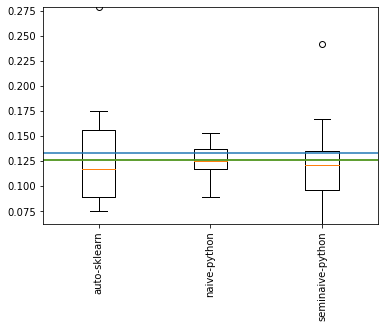

23 log_loss
Best score: 0.8926310108043704
Win for auto-sklearn
	auto-sklearn 0.8926 (0.0383)
	naive-python 1.0116 (6.0914)
	seminaive-python 0.9219 (0.0578)


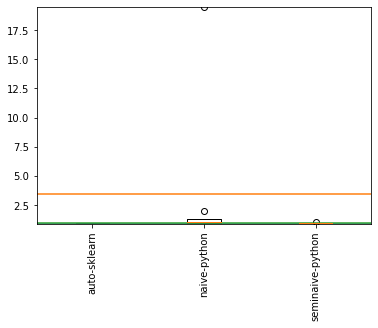

31 auc
Best score: 0.7757142857142857
	auto-sklearn 0.7667 (0.0454)
	naive-python 0.7477 (0.0542)
Win for seminaive-python
	seminaive-python 0.7757 (0.0495)


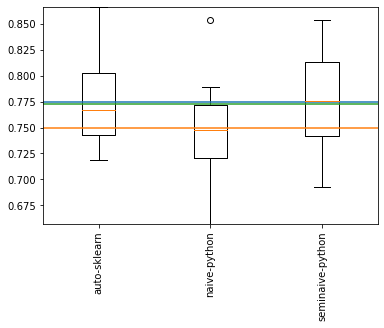

54 log_loss
Best score: 0.3558006388839253
Win for auto-sklearn
	auto-sklearn 0.3558 (0.0419)
	seminaive-python 0.4198 (0.1239)


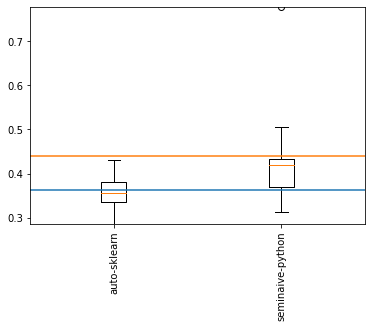

181 log_loss
Best score: 1.0852540421623467
Win for auto-sklearn
	auto-sklearn 1.0853 (0.046)


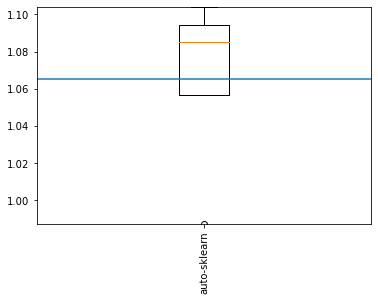

188 log_loss
Best score: 1.1069534216346437
Win for auto-sklearn
	auto-sklearn 1.107 (0.0677)
	naive-python 1.2634 (0.0892)
	seminaive-python 1.1624 (0.0678)


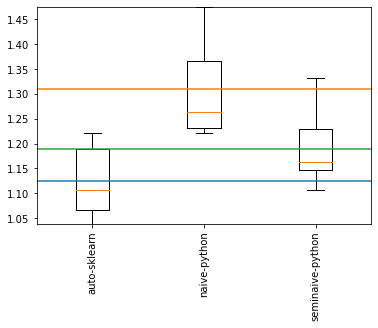

1049 auc
Best score: 0.9444444444444444
	auto-sklearn 0.942 (0.0151)
	naive-python 0.8605 (0.0457)
Win for seminaive-python
	seminaive-python 0.9444 (0.0193)


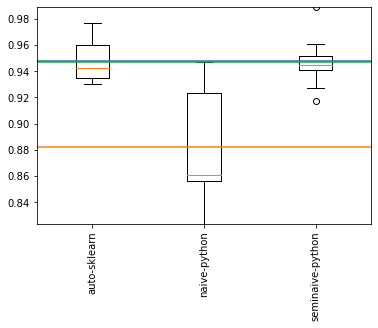

1067 auc
Best score: 0.843138966480447
Win for auto-sklearn
	auto-sklearn 0.8431 (0.0244)
	naive-python 0.8315 (0.0267)
	seminaive-python 0.8212 (0.0259)


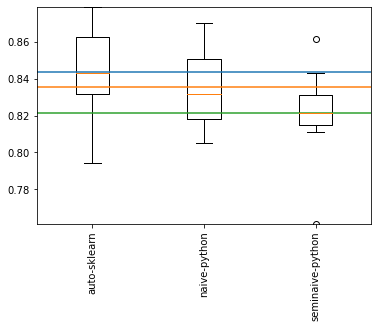

1111 auc
Best score: 0.7674253395839197
Win for auto-sklearn
	auto-sklearn 0.7674 (0.0196)
	naive-python 0.7249 (0.029)
	seminaive-python 0.7453 (0.0134)


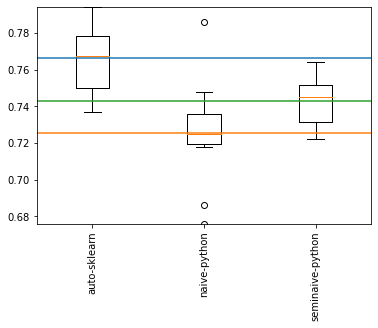

1457 log_loss
Best score: 1.1674316167894112
	auto-sklearn 1.3471 (0.2398)
	naive-python 1.255 (0.8155)
Win for seminaive-python
	seminaive-python 1.1674 (0.3112)


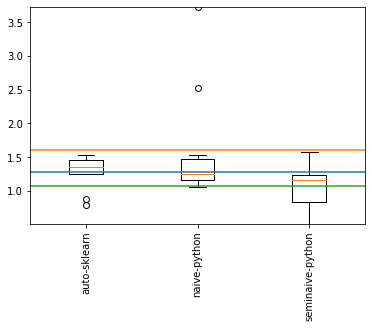

1461 auc
Best score: 0.7851045537880204
Win for auto-sklearn
	auto-sklearn 0.7851 (0.0108)
	naive-python 0.7824 (0.012)
	seminaive-python 0.7845 (0.011)


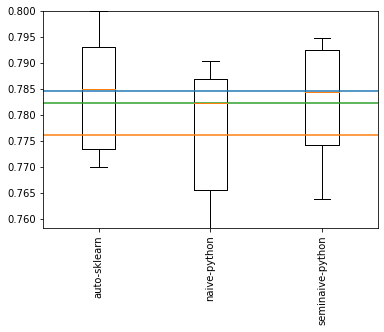

1464 auc
Best score: 0.7378167641325536
Win for auto-sklearn
	auto-sklearn 0.7378 (0.0621)
	naive-python 0.7363 (0.0993)
	seminaive-python 0.7283 (0.0593)


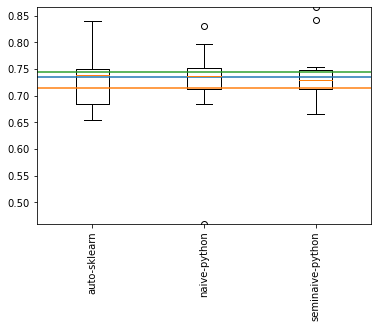

1468 log_loss
Best score: 0.1153205309410392
	auto-sklearn 0.1863 (0.0886)
	naive-python 0.153 (0.0611)
Win for seminaive-python
	seminaive-python 0.1153 (0.0336)


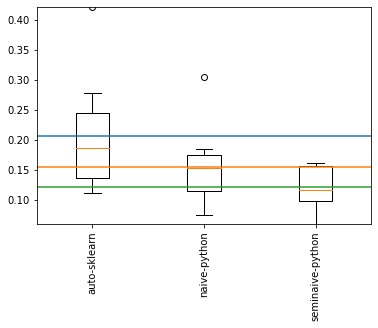

1475 log_loss
Best score: 1.0659353688651283
Win for auto-sklearn
	auto-sklearn 1.0659 (0.0317)
	naive-python 1.1412 (0.0726)
	seminaive-python 1.0796 (0.0398)


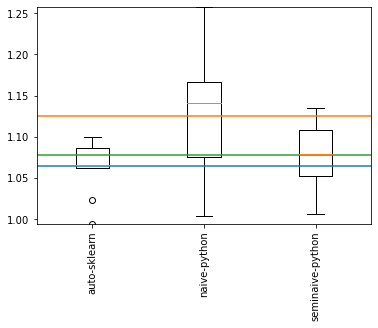

1485 auc
Best score: 0.9486834319526628
Win for auto-sklearn
	auto-sklearn 0.9487 (0.0126)
	naive-python 0.9298 (0.0087)
	seminaive-python 0.9119 (0.0189)


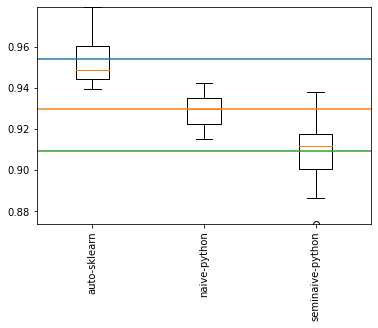

1486 auc
Best score: 0.988554028904669
Win for auto-sklearn
	auto-sklearn 0.9886 (0.0015)
	naive-python 0.9869 (0.0017)
	seminaive-python 0.9879 (0.0012)


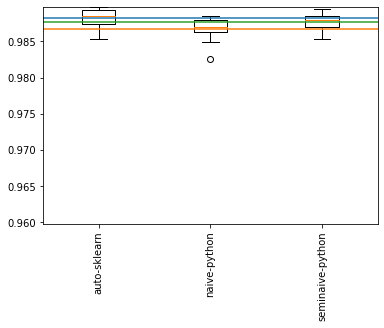

1487 auc
Best score: 0.9531909282700424
	auto-sklearn 0.9401 (0.0433)
Win for naive-python
	naive-python 0.9532 (0.0452)
	seminaive-python 0.9043 (0.0957)


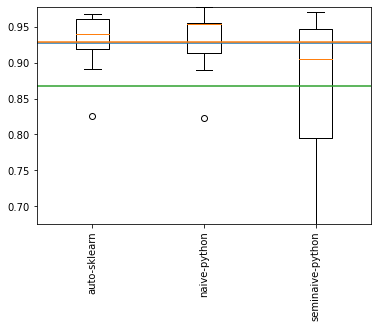

1489 auc
Best score: 0.9723305952595342
Win for auto-sklearn
	auto-sklearn 0.9723 (0.0078)
	naive-python 0.9649 (0.0076)
	seminaive-python 0.9708 (0.0325)


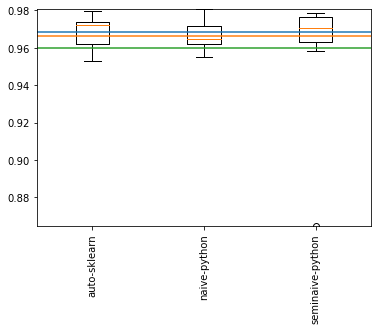

1494 auc
Best score: 0.9227053140096616
Win for auto-sklearn
	auto-sklearn 0.9227 (0.0249)
	naive-python 0.8808 (0.0)
	seminaive-python 0.9216 (0.0394)


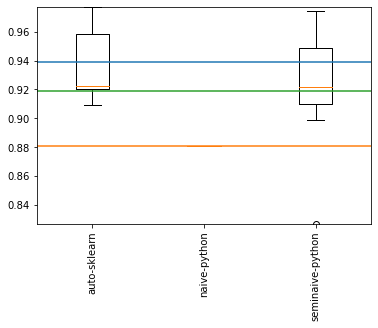

1515 log_loss
Best score: 0.42915147533905296
Win for auto-sklearn
	auto-sklearn 0.4292 (0.1408)
	naive-python 0.4877 (0.0753)
	seminaive-python 0.4759 (0.0501)


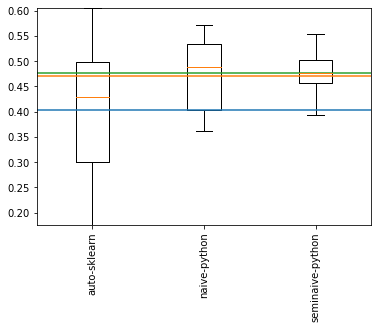

1590 auc
Best score: 0.8917869625769774
Win for auto-sklearn
	auto-sklearn 0.8918 (0.004)
	naive-python 0.8886 (0.0049)
	seminaive-python 0.8888 (0.0036)


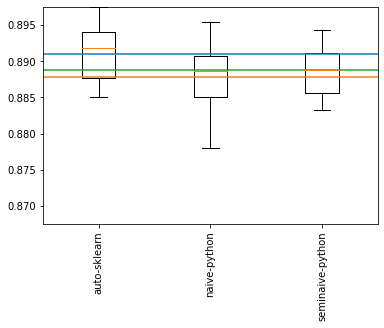

4134 auc
Best score: 0.8871402362114437
Win for auto-sklearn
	auto-sklearn 0.8871 (0.011)
	naive-python 0.8697 (0.0102)
	seminaive-python 0.8847 (0.02)


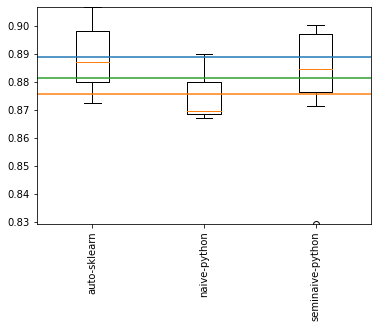

4135 auc
Best score: 0.8803648210124706
Win for auto-sklearn
	auto-sklearn 0.8804 (0.0188)
	naive-python 0.8727 (0.0192)
	seminaive-python 0.8701 (0.0209)


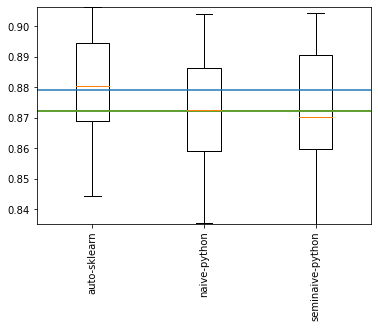

4534 auc
Best score: 0.9986109809877677
Win for auto-sklearn
	auto-sklearn 0.9986 (0.0004)
	naive-python 0.9981 (0.0016)
	seminaive-python 0.9983 (0.0006)


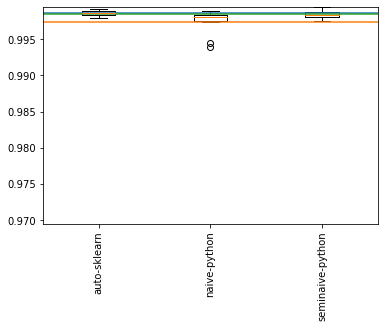

4538 log_loss
Best score: 0.8459532882296485
Win for auto-sklearn
	auto-sklearn 0.846 (0.0244)
	naive-python 0.877 (0.0402)
	seminaive-python 0.8766 (0.1564)


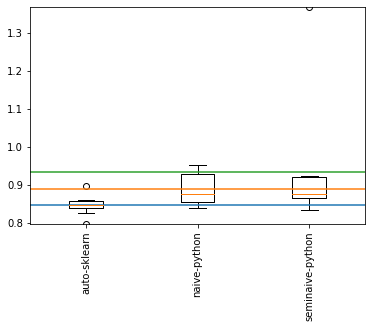

4541 log_loss
Best score: 0.895338695018989
	auto-sklearn 0.8955 (0.0041)
	naive-python 0.9225 (0.0129)
Win for seminaive-python
	seminaive-python 0.8953 (0.0018)


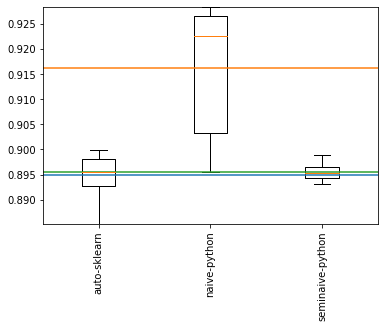

23512 auc
Best score: 0.8131807837630194
Win for auto-sklearn
	auto-sklearn 0.8132 (0.0067)
	naive-python 0.7806 (0.0058)
	seminaive-python 0.7953 (0.0571)


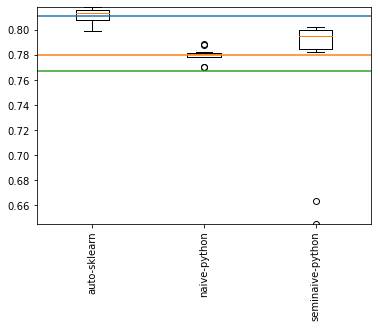

23517 auc
Best score: 0.5287876586606081
Win for auto-sklearn
	auto-sklearn 0.5288 (0.0054)
	naive-python 0.5225 (0.0118)
	seminaive-python 0.5266 (0.0057)


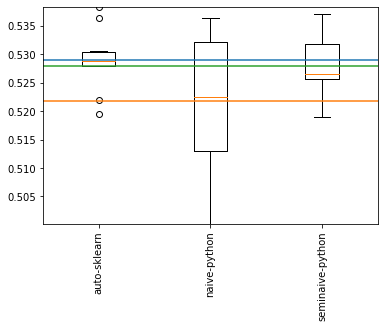

40498 log_loss
Best score: 0.7487597787893748
Win for auto-sklearn
	auto-sklearn 0.7488 (0.0315)


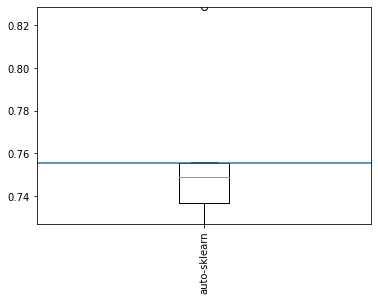

40668 log_loss
Best score: 0.18221626916428646
Win for auto-sklearn
	auto-sklearn 0.1822 (0.1195)
	naive-python 0.2801 (0.0174)
	seminaive-python 0.3273 (0.0174)


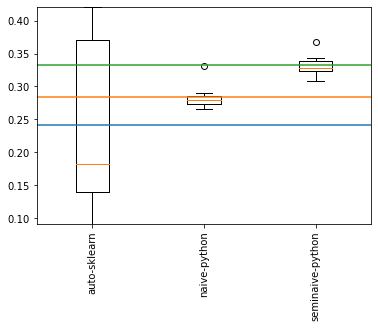

40670 log_loss
Best score: 0.0874304317951668
Win for auto-sklearn
	auto-sklearn 0.0874 (0.0246)
	naive-python 0.2009 (0.0635)
	seminaive-python 0.1034 (0.0165)


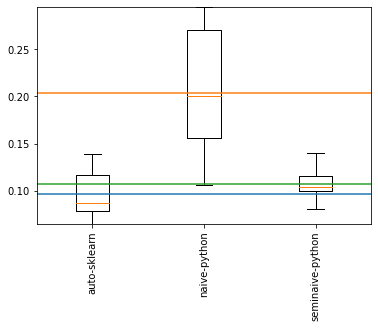

40685 log_loss
Best score: 0.0002195489730304609
Win for auto-sklearn
	auto-sklearn 0.0002 (0.0002)
	naive-python 0.0009 (0.0008)
	seminaive-python 0.0005 (0.0002)


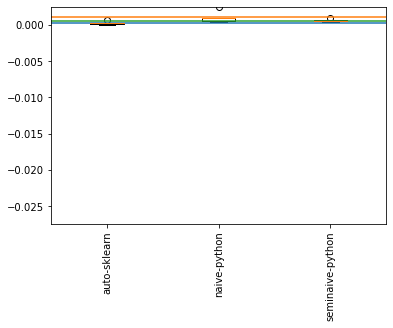

40701 auc
Best score: 0.9124252491694351
Win for auto-sklearn
	auto-sklearn 0.9124 (0.0297)
	naive-python 0.8939 (0.0193)
	seminaive-python 0.9095 (0.1154)


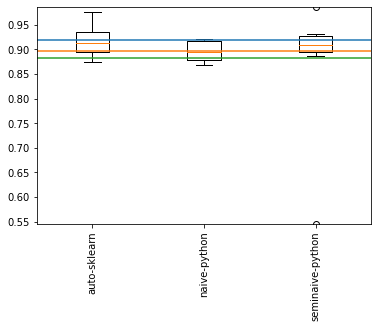

40900 auc
Best score: 0.9957669322709164
Win for auto-sklearn
	auto-sklearn 0.9958 (0.0033)
	naive-python 0.9489 (0.0989)
	seminaive-python 0.9904 (0.2648)


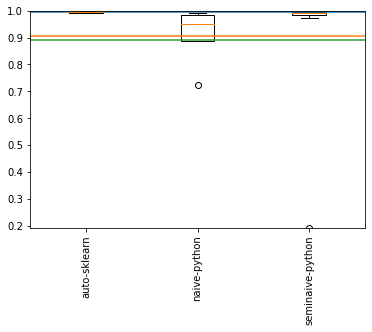

40975 log_loss
Best score: 0.0024811694906057805
Win for auto-sklearn
	auto-sklearn 0.0025 (0.0017)
	naive-python 0.1819 (0.1696)
	seminaive-python 0.0089 (0.2287)


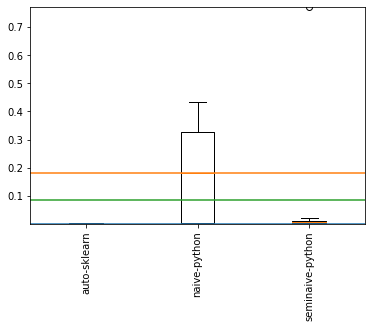

40978 auc
Best score: 0.9870632116215154
	auto-sklearn 0.9827 (0.0159)
	naive-python 0.9701 (0.0336)
Win for seminaive-python
	seminaive-python 0.9871 (0.0119)


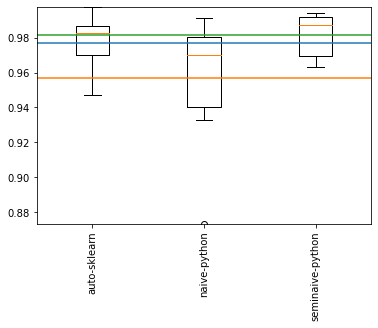

40981 auc
Best score: 0.9473684210526316
	auto-sklearn 0.9465 (0.0292)
	naive-python 0.9238 (0.0394)
Win for seminaive-python
	seminaive-python 0.9474 (0.0306)


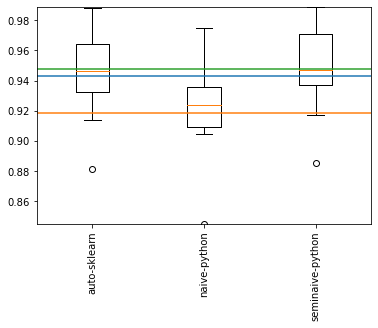

40982 log_loss
Best score: 0.5062870258155843
Win for auto-sklearn
	auto-sklearn 0.5063 (0.0495)
	seminaive-python 0.5103 (0.4474)


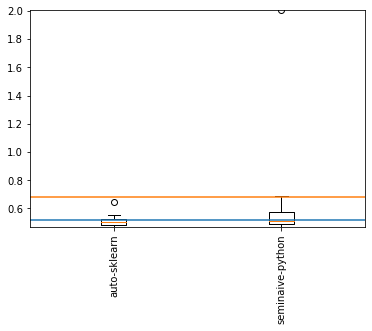

40983 auc
Best score: 0.9978576602753644
Win for auto-sklearn
	auto-sklearn 0.9979 (0.0018)
	naive-python 0.5 (0.3393)
	seminaive-python 0.689 (0.2031)


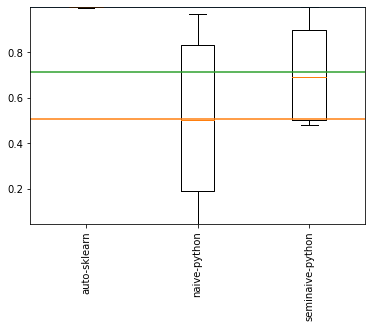

40984 log_loss
Best score: 0.06620262463821991
Win for auto-sklearn
	auto-sklearn 0.0662 (0.0239)
	naive-python 0.0733 (0.0289)
	seminaive-python 0.0768 (1.5563)


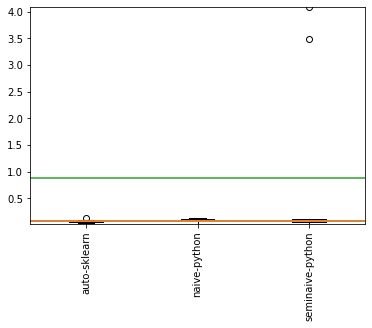

40996 log_loss
Best score: 0.2737468092874074
Win for auto-sklearn
	auto-sklearn 0.2737 (0.0248)


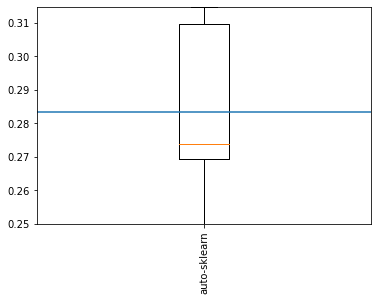

41027 log_loss
Best score: 0.1904336176124374
Win for auto-sklearn
	auto-sklearn 0.1904 (0.0483)
	naive-python 0.3013 (0.127)
	seminaive-python 0.1962 (0.0339)


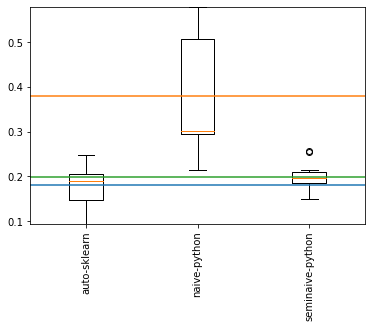

41138 auc
Best score: 0.9943771266716287
Win for auto-sklearn
	auto-sklearn 0.9944 (0.0028)
	naive-python 0.9923 (0.0027)
	seminaive-python 0.9895 (0.0026)


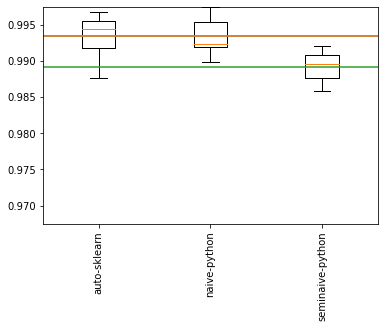

41142 auc
Best score: 0.842607341252307
Win for auto-sklearn
	auto-sklearn 0.8426 (0.0226)
	naive-python 0.8338 (0.0253)
	seminaive-python 0.8289 (0.022)


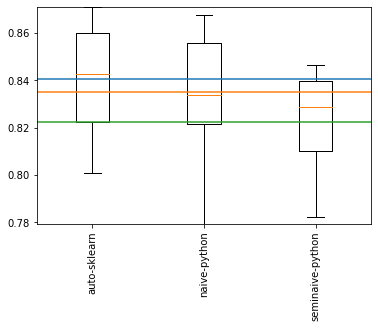

41143 auc
Best score: 0.8813116526282601
	auto-sklearn 0.8778 (0.0217)
	naive-python 0.8684 (0.0428)
Win for seminaive-python
	seminaive-python 0.8813 (0.0179)


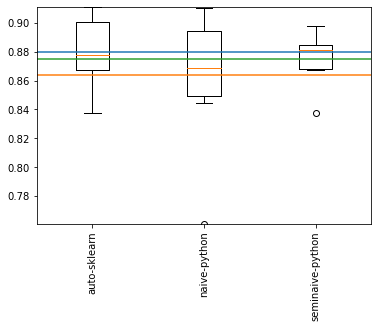

41144 auc
Best score: 0.9695525173435028
Win for auto-sklearn
	auto-sklearn 0.9696 (0.0065)
	naive-python 0.9556 (0.0)
	seminaive-python 0.9353 (0.144)


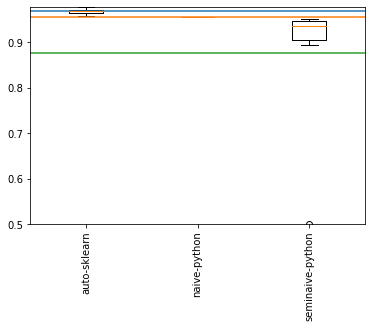

41145 auc
Best score: 0.9322365014357672
Win for auto-sklearn
	auto-sklearn 0.9322 (0.011)
	naive-python 0.7898 (0.0239)
	seminaive-python 0.8855 (0.023)


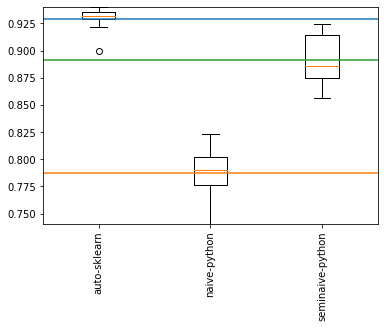

41146 auc
Best score: 0.9929580688476562
Win for auto-sklearn
	auto-sklearn 0.993 (0.0025)
	naive-python 0.9914 (0.0026)
	seminaive-python 0.9907 (0.003)


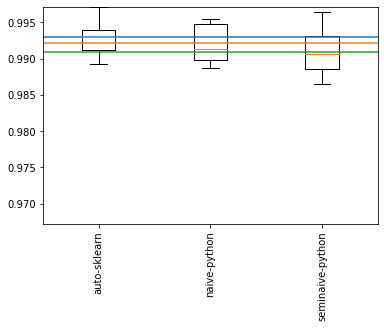

41147 auc
Best score: 0.733163260076318
Win for naive-python
	naive-python 0.7332 (0.0025)
	seminaive-python 0.733 (0.0026)


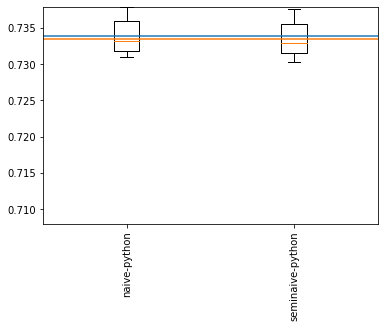

41150 auc
Best score: 0.9872263055866282
Win for auto-sklearn
	auto-sklearn 0.9872 (0.0006)
	naive-python 0.9684 (0.0012)
	seminaive-python 0.9806 (0.0007)


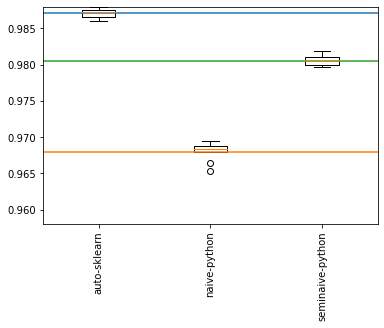

41156 auc
Best score: 0.9224829650058477
Win for auto-sklearn
	auto-sklearn 0.9225 (0.0158)
	naive-python 0.9145 (0.0171)
	seminaive-python 0.9139 (0.0459)


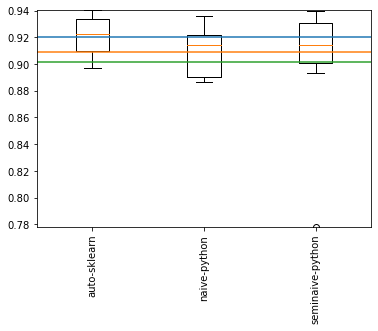

41157 auc
Best score: 0.9591666666666667
	auto-sklearn 0.8975 (0.0846)
	naive-python 0.9583 (0.2048)
Win for seminaive-python
	seminaive-python 0.9592 (0.0555)


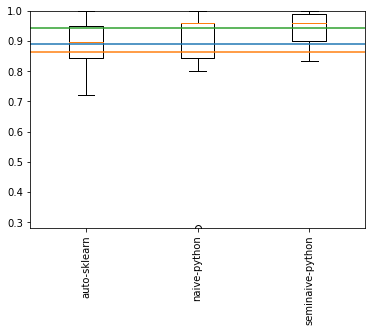

41158 auc
Best score: 0.9945766129032259
Win for auto-sklearn
	auto-sklearn 0.9946 (0.0043)
	naive-python 0.9907 (0.0032)
	seminaive-python 0.9908 (0.003)


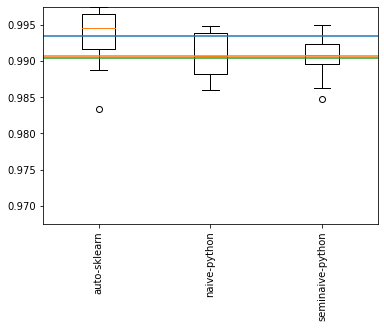

41159 auc
Best score: 0.9200788753098972
Win for auto-sklearn
	auto-sklearn 0.9201 (0.0056)
	naive-python 0.8894 (0.0058)
	seminaive-python 0.9093 (0.0574)


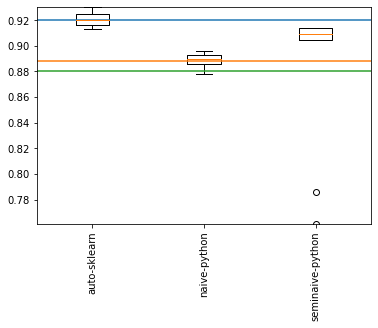

41161 auc
Best score: 0.9998306666666668
Win for auto-sklearn
	auto-sklearn 0.9998 (0.0002)
	naive-python 0.9977 (0.1197)
	seminaive-python 0.9994 (0.0003)


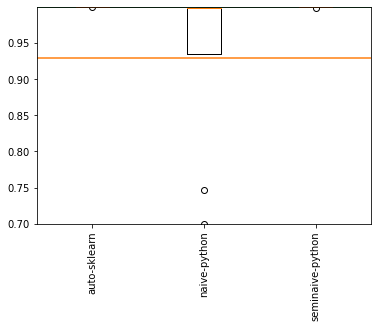

41162 auc
Best score: 0.7521233341331779
Win for auto-sklearn
	auto-sklearn 0.7521 (0.0087)
	naive-python 0.7329 (0.0072)
	seminaive-python 0.7367 (0.0083)


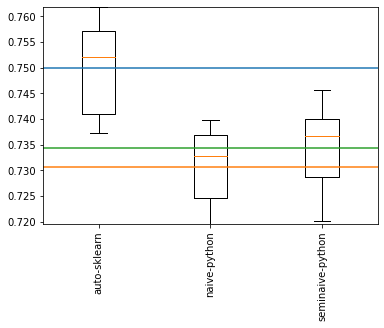

41163 log_loss
Best score: 0.023173094239884204
Win for auto-sklearn
	auto-sklearn 0.0232 (0.0203)
	naive-python 0.0459 (0.0078)
	seminaive-python 0.0478 (0.0078)


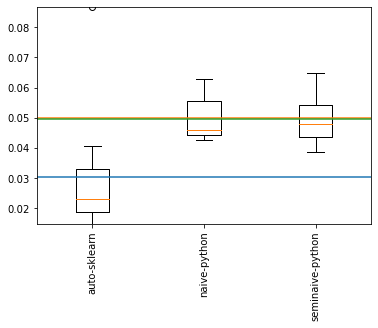

41164 log_loss
Best score: 0.796528737630974
Win for auto-sklearn
	auto-sklearn 0.7965 (0.0337)
	naive-python 0.8408 (0.0374)
	seminaive-python 0.8168 (0.0355)


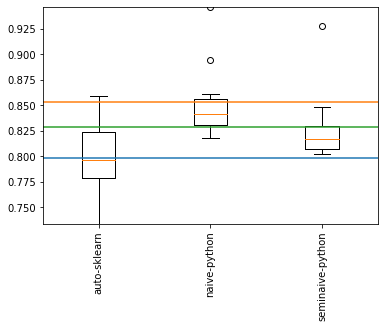

41165 log_loss
Best score: 1.687816282117154
Win for auto-sklearn
	auto-sklearn 1.6878 (0.1581)
	naive-python 1.7176 (0.0099)
	seminaive-python 1.7135 (0.2237)


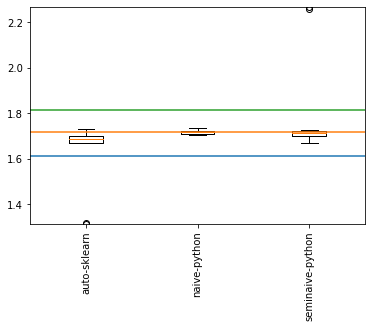

41166 log_loss
Best score: 0.8464826919525446
Win for auto-sklearn
	auto-sklearn 0.8465 (0.0717)
	naive-python 1.0292 (0.0451)
	seminaive-python 0.9444 (0.0218)


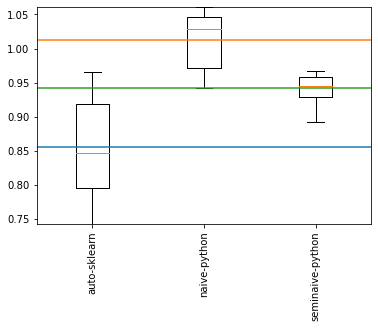

41167 log_loss
Best score: 2.1331102201054426
Win for auto-sklearn
	auto-sklearn 2.1331 (0.5669)
	seminaive-python 2.3496 (0.0)


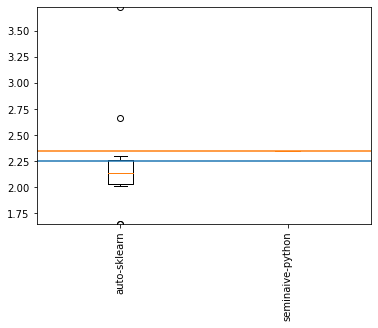

41168 log_loss
Best score: 0.6787106462841437
Win for auto-sklearn
	auto-sklearn 0.6787 (0.0218)
	naive-python 0.8062 (0.0179)
	seminaive-python 0.7416 (0.0177)


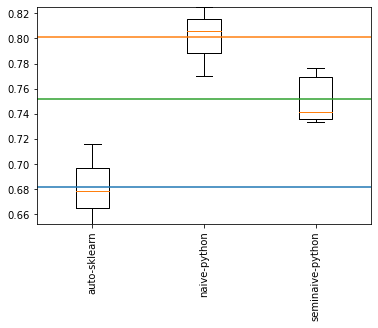

41169 log_loss
Best score: 2.6527814200075497
	auto-sklearn 2.7146 (0.171)
	naive-python 2.8 (0.0175)
Win for seminaive-python
	seminaive-python 2.6528 (0.0541)


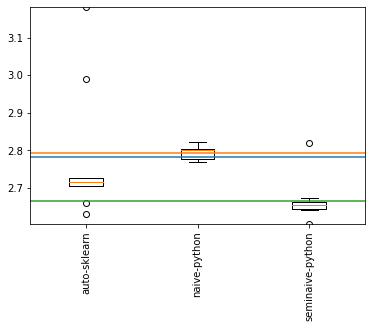

42732 auc
Best score: 0.6435656558349798
	auto-sklearn 0.6407 (0.0058)
Win for naive-python
	naive-python 0.6436 (0.0018)
	seminaive-python 0.6424 (0.002)


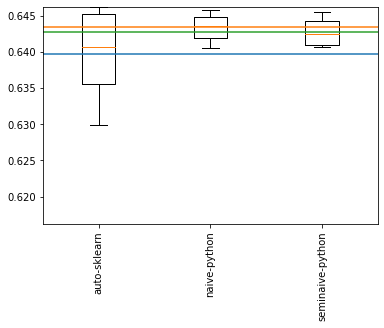

42733 auc
Best score: 0.637363096128598
Win for auto-sklearn
	auto-sklearn 0.6374 (0.0097)
	naive-python 0.6151 (0.015)
	seminaive-python 0.6118 (0.0161)


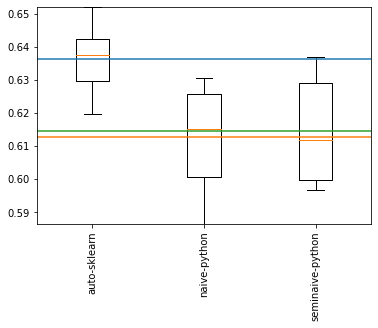

{'auto-sklearn': 53, 'seminaive-python': 11, 'naive-python': 3}


In [21]:
wins = {}
for openmlid, dfDataset in dfResults[(dfResults["timeout"] == 86400)].groupby("openmlid"):
    print(openmlid, metrics[openmlid])
    boxes = []
    labels = []
    vmax = None
    vmin = None
    is_max = metrics[openmlid] == "auc"
    medians = [np.nanmedian(dfAlgo["metric"].values) for algorithm, dfAlgo in dfDataset.groupby("algorithm")]
    best_median = max(medians) if is_max else min(medians)
    print("Best score:", best_median)
    
    means = []
    for algorithm, dfAlgo in dfDataset.groupby("algorithm"):
        #if algorithm == "auto-sklearn":
         #   minority_coalescer_counter = 0
            #for j, row in dfAlgo.iterrows():
             #   minority_coalescer_counter += ("minority_coalescer" in row["chosenmodel"])
            #print(minority_coalescer_counter / len(dfAlgo))
        boxes.append(dfAlgo["metric"].values)
        labels.append(algorithm)
        if vmin is None:
            vmin = min(dfAlgo["metric"].values)
            vmax = max(dfAlgo["metric"].values)
        else:
            vmin = min(vmin, min(dfAlgo["metric"].values))
            vmax = max(vmax, max(dfAlgo["metric"].values))
            
        mean = np.nanmean(dfAlgo["metric"].values)
        median = np.nanmedian(dfAlgo["metric"].values)
        win = (median >= best_median and is_max) or (median <= best_median and not is_max)
        if win:
            print("Win for", algorithm)
            if algorithm in wins:
                wins[algorithm] += 1
            else:
                wins[algorithm] = 1
        means.append(mean)
        print("\t" + algorithm, np.round(np.median(dfAlgo["metric"]), 4), "(" + str(np.round(np.std(dfAlgo["metric"]), 4)) + ")")
    
    vmin = min(vmin, vmax - 0.03)
    
    fig, ax = plt.subplots()
    ax.boxplot(boxes)
    for i, mean in enumerate(means):
        ax.axhline(mean, color="C" + str(i))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylim([vmin, vmax])
    plt.show()
print(wins)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe535c32a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe535d14890>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe535df0710>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe535c5fcd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe535cc8f90>,
 'means': []}

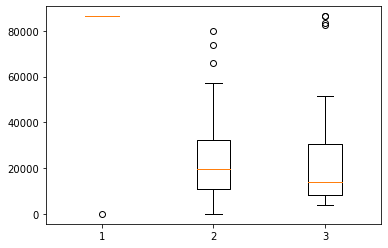

In [276]:
def get_runtimes(performance_curves):
    runtimes = {}
    for openmlid, curves_for_dataset in performance_curves.items():
        runtimes[openmlid] = [c["times"][-1] if len(c["times"]) > 0 else 0 for c in curves_for_dataset]
    return runtimes

vals_asklearn = []
vals_naive = []
vals_semi = []
for _, vals in get_runtimes(performance_curves).items():
    vals_asklearn.append(vals[0])
    if vals[1] != 0:
        vals_naive.append(vals[1])
    if vals[2] != 0:
        vals_semi.append(vals[2])
plt.boxplot([vals_asklearn, vals_naive, vals_semi])

In [51]:
pd.unique(dfResults["algorithm"])

array(['auto-sklearn', 'seminaive-python'], dtype=object)

## Result Table

In [174]:
def get_result_table(df):
    
    rows = []
    algos = list(pd.unique(df["algorithm"]))
    for openmlid, dfDataset in df.groupby("openmlid"):
        row = [openmlid, metrics[openmlid]]
        for algorithm in algos:
            dfAlgo = dfDataset[dfDataset["algorithm"] == algorithm]
            row.append(dfAlgo["metric"].values)
        rows.append(row)
    
    return pd.DataFrame(rows, columns=["openmlid", "metric"] + algos)

def get_formatted_table(table, row_func):
    
    rows = []
    for i, row in table.iterrows():
        rows.append(row_func(row))
    return pd.DataFrame(rows, columns=table.columns)

def my_format(row):
    new_row = []
    for i, val in enumerate(row):
        if i <= 1:
            new_row.append(val)
        else:
            new_row.append(np.nanmedian(val))
    return new_row

df_result_table = get_result_table(dfResults[dfResults["timeout"] == 3600])
df_result_table

,openmlid,metric,auto-sklearn,seminaive-python,naive-python,gama
0,3,auc,"[1.0, 1.0, 0.9999586024176188, 0.9999580466521...","[1.0, 1.0, 0.999793012088094, 1.0, 0.999705275...","[1.0, 1.0, 0.9978059281337971, 1.0, 0.98712535...","[0.9994773028828756, 1.0, 0.999337638681901, 0..."
1,12,log_loss,"[0.16097709980337638, 0.14230992989701247, 0.1...","[0.1125839286356022, 0.15814217616137038, 0.12...","[0.1151652711656102, 0.15055516314859488, 14.4...","[0.15914156784443406, 0.18373019246657704, 0.2..."
2,23,log_loss,"[0.8794201014784631, 0.953651822891606, 0.9377...","[0.8845807115382553, 0.9894136289573484, 0.928...","[1.0652806747300902, 1.2697519880742456, 1.818...","[0.8970617479855751, 0.9541787390654488, 0.943..."
3,31,auc,"[0.7685714285714287, 0.7933333333333334, 0.871...","[0.7476190476190476, 0.7761904761904762, 0.852...","[0.7414285714285714, 0.5, 0.8538095238095238, ...","[0.76, 0.7757142857142857, 0.8666666666666667,..."
4,54,log_loss,"[0.39974096893431377, 0.5099302851216317, 0.42...","[0.36838754101931936, 0.4804562186194406, 0.36...","[1.3530960545111377, 1.3892291400554293, 0.525...","[0.48895403812311106, 0.3304715582085343, 0.42..."
...,...,...,...,...,...,...
61,41167,log_loss,"[5.872117789475415, 5.872117789475415, 5.87211...",[],[],"[3.5945906176953097, 19.289000936099924, 17.78..."
62,41168,log_loss,"[0.7934836218568275, 0.7781800804704431, 0.690...","[0.7998746332348228, 0.7833824930027707, 0.804...","[0.8119243219029633, 0.8031965024705956, 0.829...","[0.7402313133493167, 0.7503984940171213, 0.716..."
63,41169,log_loss,"[3.0957445182613195, 3.957400786213042, 4.0847...","[3.0553906238711708, 3.0603365053145803, 3.090...","[3.238927800091194, 3.252778373356102, 3.28600...","[3.0360680872950154, 3.3026619287157946, 3.948..."
64,42732,auc,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.6394247490297751, 0.6373971216681413, 0.641...","[0.6393099931252609, 0.6371160876726355, 0.641...","[0.6423998919698609, 0.6417314481392036, 0.516..."


In [185]:
for i, row in get_formatted_table(df_result_table, my_format).iterrows():
    if row["metric"] == "log_loss":
        continue
    all_scores = np.array([row["gama"], row["seminaive-python"]])
    best_score = min(all_scores) if row["metric"] == "log_loss" else max(all_scores)
    if best_score >= row["seminaive-python"] + 0.02:
        
        print(row, best_score, all_scores <= best_score if row["metric"] == "log_loss" else all_scores >= best_score)
        #and (row["gama"] >= row["naive-python"] and row["gama"] >= row["seminaive-python"] and row["gama"] >= row["auto-sklearn"]):
        #    print(row)

openmlid                1485
metric                   auc
auto-sklearn        0.931657
seminaive-python    0.913817
naive-python        0.920059
gama                0.937396
Name: 15, dtype: object 0.937396449704142 [ True False]
openmlid                1494
metric                   auc
auto-sklearn         0.93357
seminaive-python     0.91665
naive-python        0.906602
gama                0.937959
Name: 19, dtype: object 0.9379591836734694 [ True False]
openmlid                4135
metric                   auc
auto-sklearn        0.834887
seminaive-python    0.822939
naive-python        0.803552
gama                0.846761
Name: 23, dtype: object 0.8467607116161265 [ True False]
openmlid               40983
metric                   auc
auto-sklearn        0.997326
seminaive-python    0.553307
naive-python        0.570877
gama                0.996995
Name: 39, dtype: object 0.9969949666518327 [ True False]
openmlid               41144
metric                   auc
auto-sklearn       